# 

#### How to run this Notebook:

To run the notebook, place the student_data.csv file in the same folder as the .ipynb file.
All imports work with this local file.


# Table of Contents:
- [Problem framing](#problem-framing)
- [Initial Data Inspection](#initial-data-inspection)
- [High-level EDA (Overview)](#high-level-eda-overview)
- [Detailed EDA (numeric features)](#detailed-eda-numeric-features)
- [Detailed EDA (categorical features)](#detailed-eda-categorical-features)
- [Data Cleaning](#data-cleaning)
- [Feature engineering (pre-split, leakage-safe)](#featureengineering-pre-split-leakage-safe)
- [Logistic Regression Multiclass (baseline)](#logistic-regression-multiclass-baseline)
- [Logistic Regression with Interaction and Log Features](#model-2-logistic-regression-with-interaction-and-log-features)
- [Model 3: Logistic Regression with PCA](#model-3-logistic-regression-with-pca)
- [Model 4: Random Forest](#model-4-random-forest)
- [Classification summary and model choice](#classification-summary-and-model-choice)
- [Regression task: predicting continuous student score](#regression-task-predicting-continuous-student-score)
- [Model 5: Baseline Linear Regression](#model-5-baseline-linear-regression)
- [Model 6: Ridge Regression](#model-6-ridge-regression)
- [Conclusion](#conclusion)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## <a id="problem-framing"></a>Problem framing

### Business context

An online learning platform runs a course for students.
For each student we have:
- demographic information (`age`, `birthdate`, `sex`, `country`),
- engagement signals during the course (`logged in`, `lessons`, `assignments`, `posts`),
- participation in support programs (`mentoring`, `orientation`),
- final course performance (`score`).

The university wants to understand **which behavioural patterns are linked to course success** and whether **mentoring** **orientation course** actually supports better outcomes.

### Objective

>This is a **supervised learning** and analysis problem:
>**Prediction**: Build a model to predict a student's final score (and/or its category: low/mid/high) from demographic and behavioral features, both for early risk detection and performance analysis.
>**Analysis**: Identify the most important behavioral signals and clarify the association of mentoring/orientation with outcomes, controlling for demographics.

### Stakeholders & decisions

The model and analysis should help:

- **Student success team** – early identification at-risk students early and offer support.
- **Program coordinators** – validate the added value of mentoring/orientation.
- **Platform / product team** – prioritize effective engagement features.

### Assumptions & constraints

- Data may be collected at different times;
  `age` is interpreted as the age at the time of data collection, not today.
- `score` is final and aligned with engagement features from the same period.
- `mentoring` and `orientation` are binary: 1 = participated, 0 = did not.
- data may contain inconsistencies and will require cleaning.
- no assumption of causality: models are for association/risk detection, not for proving direct effect.

In [2]:

df = pd.read_csv('student_data.csv')

## <a id="initial-data-inspection"></a>Initial Data Inspection

In [3]:
df.head(15)

,Unnamed: 0,sex,age,birthdate,country,logged in,lessons,assignments,posts,mentoring,score,orientation
0,0,NaN,24.0,2000-06-30,Austrai,5.297479,4.0,1.0,3.0,Yes,44.452539,1.0
1,1,Female,21.0,2002-11-29,Germany,3.051044,1.0,0.0,6.0,No,18.985095,0.0
2,2,Male,21.0,2003-03-25,Other,25.042989,5.0,1.0,8.0,Yes,52.182803,0.0
3,3,Female,21.0,2003-03-25,France,6.482670,1.0,0.0,3.0,No,24.172925,1.0
4,4,Female,29.0,1994-12-28,Germany,9.786313,1.0,0.0,10.0,No,39.749603,1.0
5,5,Male,25.0,1999-04-17,Germany,20.998534,6.0,0.0,2.0,No,18.550018,0.0
6,6,Female,20.0,2003-12-17,Austria,26.669448,2.0,0.0,5.0,No,25.175535,0.0
7,7,Female,24.0,2000-04-19,Austria,22.664821,1.0,0.0,3.0,No,19.454816,0.0
8,8,NaN,23.0,2001-07-13,Other,17.140537,3.0,0.0,4.0,Yes,44.009339,1.0
9,9,Male,17.0,2007-02-02,Other,23.285957,1.0,0.0,7.0,No,27.923829,0.0


In [4]:
df.tail()

,Unnamed: 0,sex,age,birthdate,country,logged in,lessons,assignments,posts,mentoring,score,orientation
495,495,NaN,32.0,1993-08-27,Other,21.660886,5.0,1.0,11.0,Yes,61.108875,1.0
496,496,Female,20.0,2004-05-15,France,7.812790,10.0,1.0,4.0,Yes,41.703814,0.0
497,497,Male,21.0,2003-09-18,Other,22.240875,1.0,0.0,4.0,Yes,37.887868,0.0
498,498,Non-Binary,23.0,2001-05-11,Italy,8.386061,2.0,0.0,6.0,No,22.678507,0.0
499,499,Female,23.0,02/03/2001,Other,34.492238,NaN,0.0,7.0,No,38.749771,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   500 non-null    int64  
 1   sex          483 non-null    object 
 2   age          494 non-null    float64
 3   birthdate    488 non-null    object 
 4   country      496 non-null    object 
 5   logged in    495 non-null    float64
 6   lessons      493 non-null    float64
 7   assignments  488 non-null    float64
 8   posts        495 non-null    float64
 9   mentoring    483 non-null    object 
 10  score        495 non-null    float64
 11  orientation  494 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 47.0+ KB


In [6]:
df.shape

(500, 12)

In [7]:
df.describe()

,Unnamed: 0,age,logged in,lessons,assignments,posts,score,orientation
count,500.000000,494.000000,495.000000,493.000000,488.000000,495.000000,495.000000,494.000000
mean,249.500000,23.864372,14.066915,3.389452,0.561475,5.357576,34.998790,0.619433
std,144.481833,10.999715,13.577602,3.978914,1.311891,2.399270,15.630228,0.486018
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.687008,0.000000
25%,124.750000,20.000000,2.093709,1.000000,0.000000,4.000000,22.772791,0.000000
50%,249.500000,22.000000,10.931016,2.000000,0.000000,5.000000,32.137461,1.000000
75%,374.250000,25.000000,22.296099,5.000000,1.000000,7.000000,46.992596,1.000000
max,499.000000,125.000000,85.488737,44.000000,9.000000,14.000000,82.839089,1.000000


In [8]:
df.isnull().sum()

Unnamed: 0      0
sex            17
age             6
birthdate      12
country         4
logged in       5
lessons         7
assignments    12
posts           5
mentoring      17
score           5
orientation     6
dtype: int64

In [9]:
df.nunique()

Unnamed: 0     500
sex              7
age             33
birthdate      468
country         11
logged in      390
lessons         22
assignments      9
posts           14
mentoring        4
score          495
orientation      2
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

**Insights**:
- there is a column Unnamed: with indexes which seem unsignificant, sunject to delete during cleaning
- max in column age is 125 - will need to check this column for outliers and correct input, consider age>80 is not realistic
- max in logged in, lessons are far away from median, need to pay attention
- should turn mentoring column from categorical to numerical
- birthdate type is object, should be datetime
- maximum 17 missiing values in sex and mentoring columns but overall percent of missing values is very low
- there are no duplicates in dataset

## <a id="high-level-eda-(overview)"></a>High-level EDA (Overview)


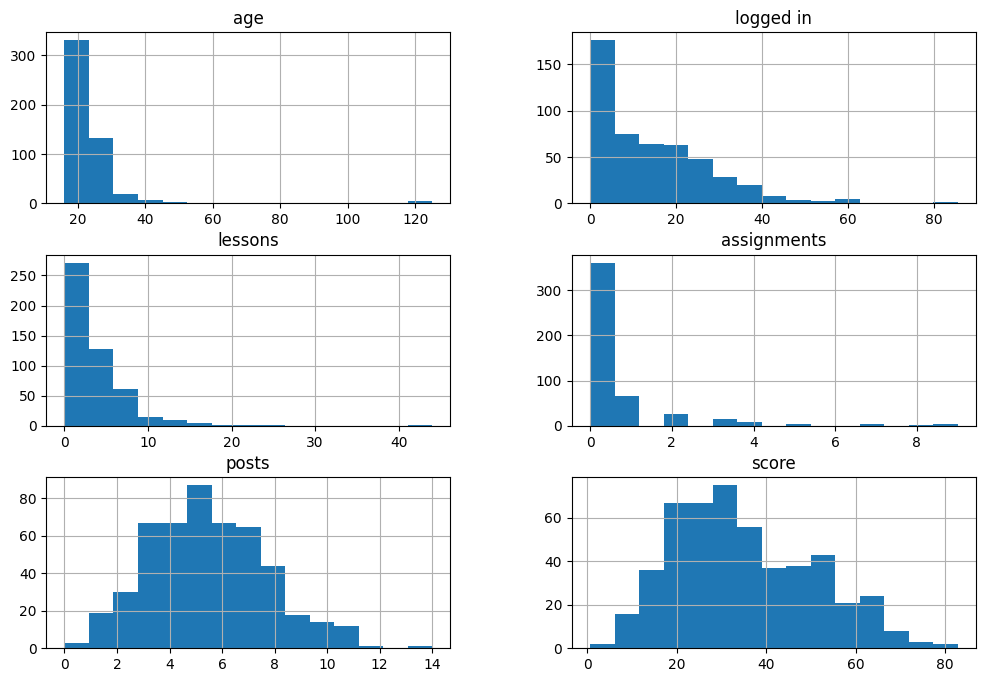

In [11]:
# distribution plots for key numerical features
import matplotlib.pyplot as plt

numeric_cols = ['age','logged in','lessons','assignments','posts','score']
df[numeric_cols].hist(bins=15, figsize=(12,8))
plt.show()

**Age** - right-skewed with extreme outliers, most students are between 18–30 years old (narrow peak).
values at 120 indicating clear entry/parsing errors.
This suggests the presence of data quality issues that will need to be addressed during cleaning.
**Initial hypothesis**: age values above 50 are likely invalid.

**Logged in** - heavily right-skewed, majority of students have <15 logged-in hours.
A long tail extends past 80 hours, indicating a small number of unusually active users(might be power users)
**Initial hypothesis**: Not a data error — but a behavioral skew.

**Lessons** - heavily right-skewed, most students completed 0–5 lessons.
Outliers reach 20–40+ lessons. These high values may be legitimate but deserve further inspection.
**Initial hypothesis**: Potential behavioral outliers, but not necessarily errors.

**Assignments** - nearly zero-inflated
Many students have 0 assignments submitted.
A small number go up to 9, producing a long tail.
Strong asymmetry suggests that assignment volume is highly imbalanced.
**Initial hypothesis**: This pattern may affect the model later (variance, class imbalance).

**Posts** - the only almost-normal distribution
Most students post between 3–8 messages, with few extremes.
This makes posts the most statistically stable engagement metric.
**Initial hypothesis**: Likely to behave well in linear models.

**Score** - moderately right-skewed
Score spans 0–80+, with a large mass around 20–40.
The distribution is somewhat asymmetric but not extreme.

Across all features, the data exhibits strong right-skew, heavy tails, behavioral heterogeneity.
Only age shows implausible values likely caused by incorrect input or date parsing errors.
All engagement features (logged in, lessons, assignments, posts) appear realistic but imbalanced, indicating different student activity types.

<a id="high-level-eda-categorical-features"></a>
## High-level EDA: categorical features

For easier interpretation some categorical features as `mentoring` is better to turn to numbers for easier interpretation as it's already done with `orientation` 

In [12]:
df['mentoring'].value_counts()

mentoring
No     283
Yes    178
N       14
Y        8
Name: count, dtype: int64

In [13]:
# convert boolean for easier interpretation during EDA

df['mentoring'] = df['mentoring'].map({'Yes': 1, 'Y': 1, 'No': 0, 'N': 0})

In [14]:
df.isna().sum()

Unnamed: 0      0
sex            17
age             6
birthdate      12
country         4
logged in       5
lessons         7
assignments    12
posts           5
mentoring      17
score           5
orientation     6
dtype: int64

In [15]:
df['mentoring'].value_counts()

mentoring
0.0    297
1.0    186
Name: count, dtype: int64

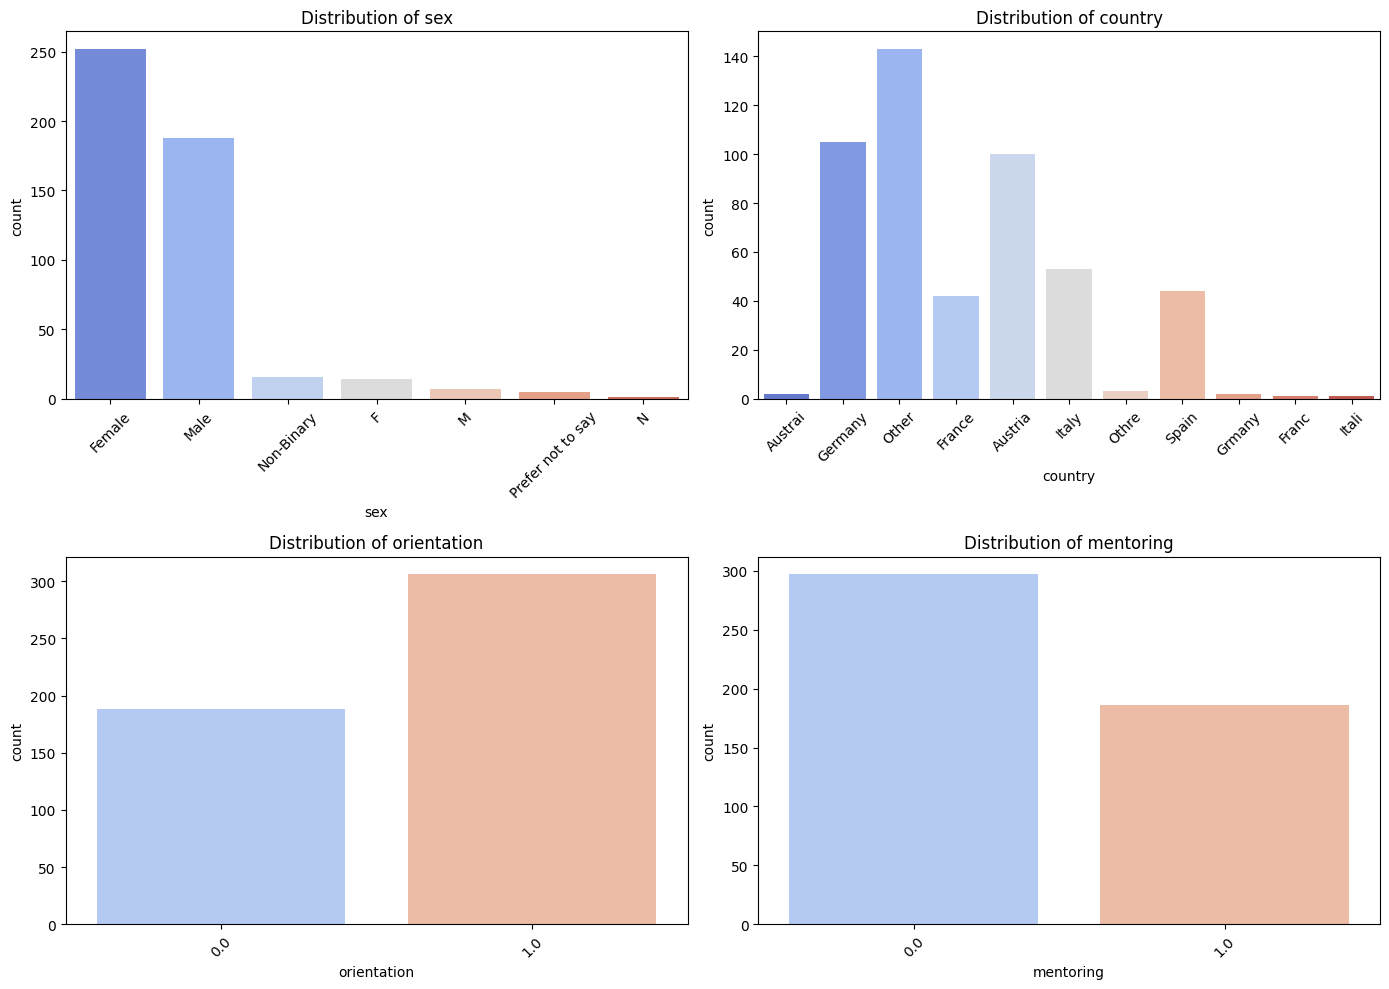

In [16]:
cat_cols = ['sex', 'country', 'orientation', 'mentoring'] # despite mentoring and orientation contains numbers it's categorical by nature yes/no

plt.figure(figsize=(14, 10))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=col, hue=col, palette='coolwarm', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [17]:
df['sex'].value_counts()

sex
Female               252
Male                 188
Non-Binary            16
F                     14
M                      7
Prefer not to say      5
N                      1
Name: count, dtype: int64

In [18]:
df['country'].value_counts()

country
Other      143
Germany    105
Austria    100
Italy       53
Spain       44
France      42
Othre        3
Austrai      2
Grmany       2
Franc        1
Itali        1
Name: count, dtype: int64

In [19]:
df['orientation'].value_counts()

orientation
1.0    306
0.0    188
Name: count, dtype: int64

In [20]:
df['mentoring'].value_counts()

mentoring
0.0    297
1.0    186
Name: count, dtype: int64

### Categorical Feature Insigts:
- inconsistent naming in **sex** (will be fixed later)
- wrong naming and rare categories in **country** (will be fixed later as well)
- strong imbalance in **mentoring** and **orientation** classes 

<a id="detailed-eda-numeric-features"></a>
## Detailed EDA (numeric features)
I now explore individual features and correlation between them in more depth to detect anomalies, validate assumptions, and identify variables that may have predictive power for the target score.

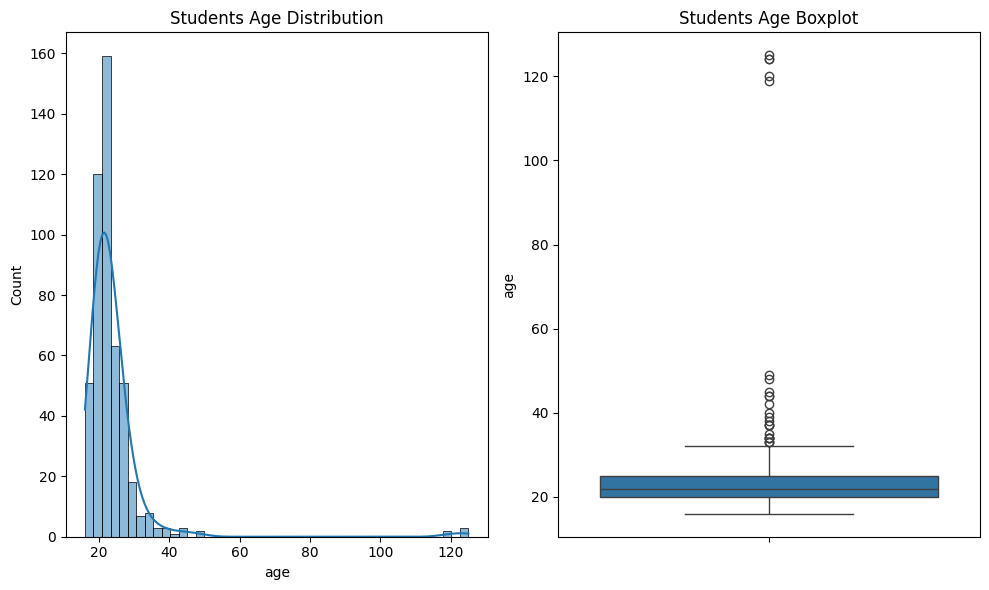

In [21]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Students Age Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['age'])
plt.title('Students Age Boxplot')

plt.tight_layout()
plt.show()

In [22]:
# let's manually check outliers data, I choose max age 60 as realistic age for a person in univercity

df[df['age'] > 60][['birthdate', 'age']]

,birthdate,age
73,13/05/1899,125.0
164,1905-04-27,119.0
219,1900-06-28,124.0
242,1900-06-02,124.0
460,1903-11-09,120.0


There are 5 lines with birthdate clearly unrealistic - and these 5 values ​​are not meaningful outliers but clear data entry errors.

Keeping these rows affects every subsequent visualization and statistical test by artificially stretching the distribution and distorting summary statistics.

Since these are structural errors rather than natural variability, they are corrected immediately at the EDA stage by setting age and the associated birthdate values ​​to NaN:.
Because age and birthdate technically two features but have the same meaning we only should use one of the for a model.
However it worth to check age-birthdate for consistency as I already see inreliable data.

In [23]:
bad_indices = [73, 164, 219, 242, 460]  # indexes of users with wrong age-birthdate
df.loc[bad_indices, 'age'] = np.nan
df.loc[bad_indices, 'birthdate'] = np.nan

In [24]:
df[['age', 'birthdate']].describe()

,age
count,489.000000
mean,22.856851
std,4.655769
min,16.000000
25%,20.000000
50%,22.000000
75%,25.000000
max,49.000000


In [25]:
# visually observing for anomaly

print(df['birthdate'].head(30)) 
print(df['birthdate'].isna().sum())

0     2000-06-30
1     2002-11-29
2     2003-03-25
3     2003-03-25
4     1994-12-28
5     1999-04-17
6     2003-12-17
7     2000-04-19
8     2001-07-13
9     2007-02-02
10    2005-05-24
11    2001-03-31
12    1995-08-28
13    2003-03-15
14    2004-03-05
15           NaN
16    2004-05-03
17    2003-05-31
18    2002-06-24
19    2005-07-01
20    12/01/1999
21    2005-11-09
22    2006-01-29
23    2001-09-15
24    1999-06-05
25    2001-10-20
26    2002-11-01
27    11/06/2003
28    2003-12-07
29    1997-11-17
Name: birthdate, dtype: object
17


In [26]:
# I want to check if dates like 12/01/1999 is MM/DD/YYYY (USA style) or DD/MM/YYYY format and observe some manually

print(df['birthdate'].str.contains('/').sum())

mask_slash = df['birthdate'].astype(str).str.contains('/')
df.loc[mask_slash, 'birthdate'].head(10) 

48


20    12/01/1999
27    11/06/2003
35    05/07/1998
36    21/12/2004
40    30/01/1999
43    17/06/2004
46    12/02/2002
61    24/10/2003
80    03/03/2005
85    16/11/2005
Name: birthdate, dtype: object

I see  lines without birthdate

and 48 lines with different (european) date-time format

to be able to check age-birthday consistency I want to make birthdate in one date-time standart and also convert object type to date-time format

In [27]:
df.loc[mask_slash, 'birthdate'] = pd.to_datetime(
    df.loc[mask_slash, 'birthdate'],
    format='%d/%m/%Y',
    errors='coerce'
)

df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')

print(df['birthdate'].describe())
print(df['birthdate'].head(30))

count                              483
mean     2001-05-21 09:50:18.633540352
min                1975-01-09 00:00:00
25%                1999-08-17 00:00:00
50%                2002-04-08 00:00:00
75%                2004-04-27 00:00:00
max                2008-05-17 00:00:00
Name: birthdate, dtype: object
0    2000-06-30
1    2002-11-29
2    2003-03-25
3    2003-03-25
4    1994-12-28
5    1999-04-17
6    2003-12-17
7    2000-04-19
8    2001-07-13
9    2007-02-02
10   2005-05-24
11   2001-03-31
12   1995-08-28
13   2003-03-15
14   2004-03-05
15          NaT
16   2004-05-03
17   2003-05-31
18   2002-06-24
19   2005-07-01
20   1999-01-12
21   2005-11-09
22   2006-01-29
23   2001-09-15
24   1999-06-05
25   2001-10-20
26   2002-11-01
27   2003-06-11
28   2003-12-07
29   1997-11-17
Name: birthdate, dtype: datetime64[ns]


In [28]:
# checking age-bday consistency in dataset

today = pd.Timestamp.today()

# checking basic info before changes
print("Before:")
print("age non-null:", df['age'].notna().sum())
print("birthdate non-null:", df['birthdate'].notna().sum())


# checking consistence where both age and birthdate is present
both_present = df['age'].notna() & df['birthdate'].notna()
print("\n(both_present):", both_present.sum())

age_calc = ((today - df.loc[both_present, 'birthdate']).dt.days / 365.25)
diff = (df.loc[both_present, 'age'] - age_calc).abs()

print("\nDiff describe:")
print(diff.describe())

# two years inconsistency is an industry standart from 
inconsistent_mask = diff > 2 
print("lines with diff > 2 years:", inconsistent_mask.sum())

# checking manually first 10 suspicious 
suspect_idx = df.loc[both_present].index[inconsistent_mask]
print("\nExamples data conflict age vs birthdate:")
print(df.loc[suspect_idx, ['age', 'birthdate']].head(10))

Before:
age non-null: 489
birthdate non-null: 483

(both_present): 477

Diff describe:
count    477.000000
mean       1.890232
std        0.432304
min        0.184120
25%        1.644764
50%        1.877481
75%        2.123888
max        4.314168
dtype: float64
lines with diff > 2 years: 171

Examples data conflict age vs birthdate:
     age  birthdate
1   21.0 2002-11-29
4   29.0 1994-12-28
6   20.0 2003-12-17
9   17.0 2007-02-02
20  25.0 1999-01-12
21  18.0 2005-11-09
22  18.0 2006-01-29
25  22.0 2001-10-20
26  21.0 2002-11-01
28  20.0 2003-12-07


there are 67 lines where age and birthday is inconsistent. As we do not have any documentation for this dataset and any info how the data was gathered,
there are few options we can do about it:

- calculate correct age based on birthdate
- delete all 67 lines as we can't trust this data
- leave age as it is and ignore the difference 
- turn inconsistent age as NaN and replace as mean/median later

I do not think that all data could be gathered in the same day and even year. Hypothesis: there is a hidden feature - snapshot year - which we can find ading age given to birthday given:


In [29]:
# take only lines where both age birthdate filled
mask = df['age'].notna() & df['birthdate'].notna()

# calculating possible snapshot year
df.loc[mask, 'snapshot_year'] = (
    df.loc[mask, 'birthdate'].dt.year + df.loc[mask, 'age']
)

print(df['snapshot_year'].describe())
print(df['snapshot_year'].value_counts().sort_index())

count     477.000000
mean     2023.737945
std         0.569245
min      2021.000000
25%      2023.000000
50%      2024.000000
75%      2024.000000
max      2026.000000
Name: snapshot_year, dtype: float64
snapshot_year
2021.0      2
2022.0      9
2023.0    114
2024.0    342
2025.0      7
2026.0      3
Name: count, dtype: int64


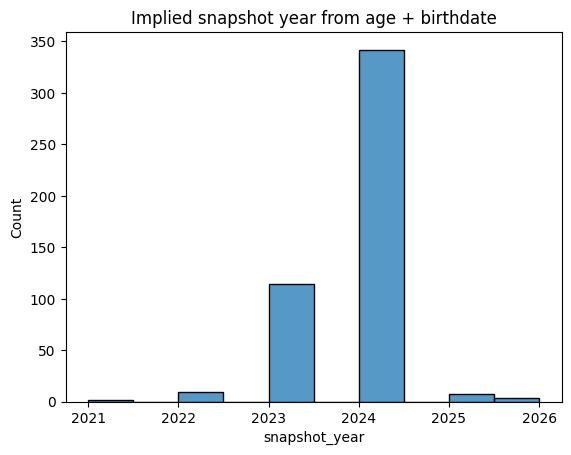

In [30]:
sns.histplot(df['snapshot_year'].dropna(), bins=10, kde=False)
plt.title('Implied snapshot year from age + birthdate')
plt.show()

In [31]:
df[df['snapshot_year'] > 2025][['age', 'birthdate', 'snapshot_year']]

,age,birthdate,snapshot_year
203,25.0,2001-07-27,2026.0
398,23.0,2003-08-19,2026.0
458,44.0,1982-06-26,2026.0


In [32]:
df.head()

,Unnamed: 0,sex,age,birthdate,country,logged in,lessons,assignments,posts,mentoring,score,orientation,snapshot_year
0,0,NaN,24.0,2000-06-30,Austrai,5.297479,4.0,1.0,3.0,1.0,44.452539,1.0,2024.0
1,1,Female,21.0,2002-11-29,Germany,3.051044,1.0,0.0,6.0,0.0,18.985095,0.0,2023.0
2,2,Male,21.0,2003-03-25,Other,25.042989,5.0,1.0,8.0,1.0,52.182803,0.0,2024.0
3,3,Female,21.0,2003-03-25,France,6.482670,1.0,0.0,3.0,0.0,24.172925,1.0,2024.0
4,4,Female,29.0,1994-12-28,Germany,9.786313,1.0,0.0,10.0,0.0,39.749603,1.0,2023.0


#### Why can `snapshot_year` show values like 2026, and why strict age-year consistency is not required

The `snapshot_year` column is derived from combining `birthdate` and `age` in the dataset. 
In reality age is continious variable while in data it mostly rounded. Simply adding age as integer to birthdate will gives us snapshot date close or the same as birth date! In practice, the actual data collection could have happened at any time after the birthday, including early next year. `snapshot_year` is my estimate of the smallest possible year, but without metadata it's a "guesstimated analysis".

**Conclusion**: Strict consistency between `age` and the `birthdate` is not required, because:
- Age most likely reflects the student's information at the time they were assessed, not at the current moment.
- Without metadata about when each data entry was collected, it's natural for age and birthdate to have minor misalignments.
- For modeling, I think it is most important to use the age value available at the time the target variable (score) was measured, not an artificially calculated current age.

Therefore, I accept minor inconsistencies and focus on trusting the recorded age for analysis. However, outliers data where `age` > 60 (actually there are just 5 lines where age is more than 100 years) is subject to replace with NaN.

## Detailed view on Numeric Features Grid

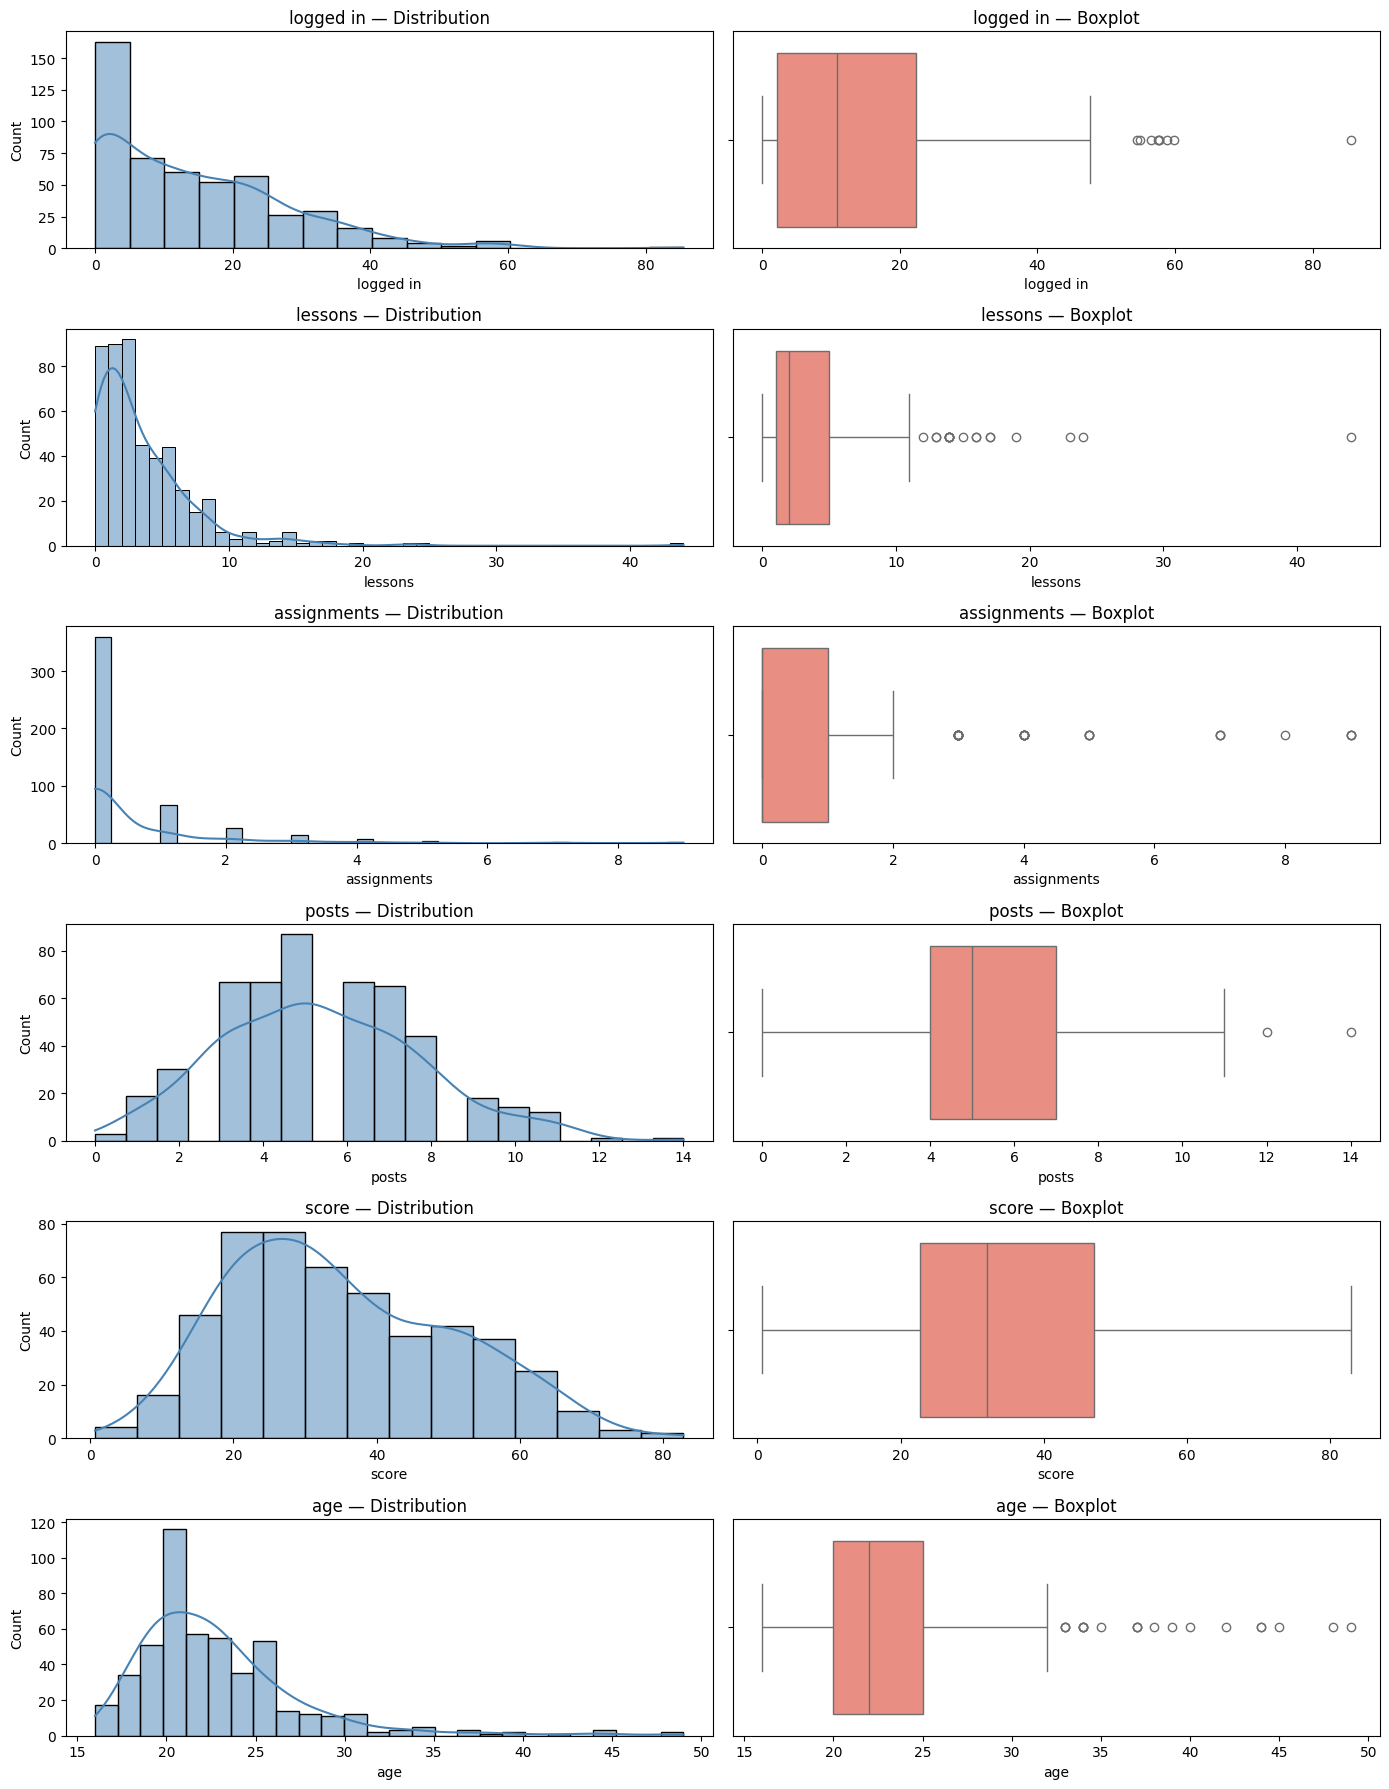

In [33]:
numeric_cols = ['logged in', 'lessons', 'assignments', 'posts', 'score', 'age']

plt.figure(figsize=(14, 3 * len(numeric_cols)))

for i, col in enumerate(numeric_cols, 1):
    
    # histogram
    plt.subplot(len(numeric_cols), 2, 2*i - 1)
    sns.histplot(df[col], kde=True, color='steelblue')
    plt.title(f'{col} — Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    
    # boxplot
    plt.subplot(len(numeric_cols), 2, 2*i)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'{col} — Boxplot')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### Observation:
- `logged_in`: strong right skew, lognormal distribution, extreme outliers around 80 hours.
- `lessons`: heavy long tail, users with > 20 lessons.
- `assignments`: extremely skewed with majority at 0–1 assignment.
- `posts`: nearly symmetric, mild right tail.
- `score`: distribution looks close to normal but have slight right skew
- `age`: visible outliers, but this age is realistic and possible for students even if it's rare.
   
Every featyre shows non-symmentric skewed distribution with some outliers which needs a manual closer view.

In [34]:
# calculating skewness and kurtosis
from scipy.stats import skew, kurtosis

numeric_cols = ['age', 'logged in', 'lessons', 'assignments', 'posts', 'score']

# ignoring NaN otherwise calculation would not work
skewness = df[numeric_cols].apply(lambda x: skew(x, nan_policy='omit')) 
kurt = df[numeric_cols].apply(lambda x: kurtosis(x, nan_policy='omit'))

skew_df = pd.DataFrame({'skewness': skewness, 'kurtosis': kurt})
skew_df

,skewness,kurtosis
age,2.092719,6.724270
logged in,1.164668,1.727464
lessons,3.562725,24.659471
assignments,3.577620,15.605789
posts,0.332140,-0.097134
score,0.443822,-0.528742


#### Skewness and Kurtosis Interpretation

To assess the shape of numeric feature distributions, we calculated **skewness** and **Fisher kurtosis** (excess kurtosis, subtracting 3 from Pearson's formula) for each variable. These metrics quantify:
- **Skewness**: The asymmetry of a distribution.
    - Positive values: long right tail (most values are low, few high outliers).
    - Negative values: long left tail (most values are high, few low outliers).
- **Fisher kurtosis**: The "peakedness" and tail-weight of the distribution compared to normal (where kurtosis = 0).
    - >0: heavier tails/more outliers than normal; <0: flatter than normal.

**Results:**
- `age`, `lessons`, and `assignments` show **very high positive skewness** and **very high kurtosis**, suggesting strong asymmetry and many outliers/extreme values (typical for count or activity features).
- `logged in` has moderate positive skewness and kurtosis, reflecting slightly asymmetric and heavy-tailed behavior.
- `posts` and `score` are close to symmetric (skewness ≈ 0), and show nearly normal or flatter distributions (kurtosis ≈ 0 or negative).

**Conclusion:**  
- Most numeric features are non-normal, with strong rightward skew and high excess kurtosis, indicating the presence of outliers and a concentration of lower values.  
- Only `posts` and `score` are closer to normal/uniform — useful for choosing transformation techniques or modeling approaches.

In [35]:
# boxplot shows us some outliers, let's take a look on it manually:
for col in numeric_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask_iqr = (df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)
    outliers_iqr = df[mask_iqr]
    print(f'IQR outliers for {col}:')
    print(outliers_iqr[numeric_cols])

IQR outliers for age:
      age  logged in  lessons  assignments  posts      score
45   45.0   0.000000      2.0          0.0    6.0  23.045043
69   35.0  11.978336      1.0          0.0    6.0  23.385451
83   37.0   8.319578      3.0          0.0    5.0  29.897739
102  37.0   0.000000      1.0          0.0    8.0  46.596899
129  48.0  14.071063      5.0          0.0    7.0  52.320210
134  34.0  21.272199      3.0          0.0    6.0  48.550182
151  42.0  27.402300      6.0          9.0    7.0  55.347047
152  33.0   2.874299      2.0          0.0    7.0  20.932107
191  33.0  14.040711      4.0          0.0    5.0  32.702393
207  37.0   0.000000      1.0          0.0    4.0   9.007409
220  33.0  20.494423      1.0          0.0    8.0  64.301104
222  49.0   9.614576      2.0          0.0    3.0  27.357520
247  34.0  29.952984      6.0          2.0    8.0  69.851202
298  38.0   0.000000      4.0          1.0    6.0  52.619544
338  40.0  13.770492      2.0          2.0    6.0  54.157919
33

#### IQR outliers insigths
IQR is a simple “mathematical marker”, not intended for heavy tails, lognormalities but it's still worth to manually look at the data IQR marked. The IQR method is sensitive to distribution (if a feature has a long tail, outliers capture more rows).
In some cases, IQR captures moderate but rare values, while z-score ignores all but the most extreme ones.
Some users have 0 hours logged in and hight activity in the rest features, should take a loook closer.

In [36]:
# calculating z-score to check data for outliers
from scipy.stats import zscore

z = df[numeric_cols].apply(lambda x: zscore(x, nan_policy='omit'))
outliers_z = (abs(z) > 3).sum()
print(outliers_z)

age            12
logged in       8
lessons         8
assignments    11
posts           1
score           1
dtype: int64


In [37]:
selected_cols = ['age', 'logged in', 'lessons', 'assignments', 'posts', 'score']

age_outliers = df[np.abs(z['age']) > 3][selected_cols]
print(age_outliers)

      age  logged in  lessons  assignments  posts      score
45   45.0   0.000000      2.0          0.0    6.0  23.045043
83   37.0   8.319578      3.0          0.0    5.0  29.897739
102  37.0   0.000000      1.0          0.0    8.0  46.596899
129  48.0  14.071063      5.0          0.0    7.0  52.320210
151  42.0  27.402300      6.0          9.0    7.0  55.347047
207  37.0   0.000000      1.0          0.0    4.0   9.007409
222  49.0   9.614576      2.0          0.0    3.0  27.357520
298  38.0   0.000000      4.0          1.0    6.0  52.619544
338  40.0  13.770492      2.0          2.0    6.0  54.157919
458  44.0   0.431332      3.0          1.0    3.0  36.902681
465  39.0   0.000000      3.0          0.0    5.0  20.486317
490  44.0  32.987031      0.0          0.0    4.0  24.014710


In [38]:
age_outliers = df[np.abs(z['logged in']) > 3][selected_cols]
print(age_outliers)

      age  logged in  lessons  assignments  posts      score
39   21.0  59.874187     14.0          0.0   10.0  49.270463
52   26.0  57.714056     44.0          0.0    9.0  42.491728
227  31.0  58.777472      8.0          3.0   11.0  65.176438
245  29.0  54.964288      2.0          0.0    4.0  24.346860
282  19.0  57.495773      6.0          1.0    8.0  35.665071
379  22.0  57.620317      5.0          0.0    7.0  31.792028
453  23.0  85.488737      7.0          0.0    8.0  63.666956
476  19.0  56.547914      4.0          0.0   10.0  38.603184


In [39]:
age_outliers = df[np.abs(z['lessons']) > 3][selected_cols]
print(age_outliers)

      age  logged in  lessons  assignments  posts      score
35   26.0  35.178762     23.0          1.0    5.0  44.204993
52   26.0  57.714056     44.0          0.0    9.0  42.491728
58   23.0  24.667765     16.0          7.0   10.0  69.101514
112  21.0  43.690615     19.0          4.0   14.0  82.839089
198  23.0  31.823674     16.0          2.0    4.0  59.309555
316  24.0  47.560802     17.0          0.0    8.0  55.606937
349  19.0  33.567794     24.0          2.0    7.0  49.342421
440  22.0  27.546924     17.0          0.0    8.0  58.634537


In [40]:
age_outliers = df[np.abs(z['assignments']) > 3][selected_cols]
print(age_outliers)

      age  logged in  lessons  assignments  posts      score
58   23.0  24.667765     16.0          7.0   10.0  69.101514
151  42.0  27.402300      6.0          9.0    7.0  55.347047
159  19.0  32.087132      8.0          7.0    3.0  62.368343
294  18.0  10.819040      8.0          5.0    5.0  41.444767
303  25.0  24.876672      7.0          5.0    3.0  54.523058
333  30.0   0.000000      4.0          5.0    9.0  49.999362
344  26.0  37.655398     13.0          8.0    7.0  72.347705
351  31.0  13.231304     11.0          7.0    9.0  67.782894
397  21.0  19.562038      9.0          9.0    8.0  80.189444
401  21.0  11.782483      4.0          5.0    6.0  49.910786
441  30.0  14.900749     11.0          9.0    6.0  67.906614


logged in time 0 but lessons 4 and score is very high - can we trust this data?

In [41]:
age_outliers = df[np.abs(z['posts']) > 3][selected_cols]
print(age_outliers)

      age  logged in  lessons  assignments  posts      score
112  21.0  43.690615     19.0          4.0   14.0  82.839089


In [42]:
age_outliers = df[np.abs(z['score']) > 3][selected_cols]
print(age_outliers)

      age  logged in  lessons  assignments  posts      score
112  21.0  43.690615     19.0          4.0   14.0  82.839089


#### z-score insigts
while most of the outliers looks like very active students, `112` is one of the most active but their behaviour possible and does not looks like mistake or data error, lines like `333` looks suspicious because there is 0 in `logged in` and the rest of activity is very high, I want to check further if this tendency is often seen in this dataframe. Also, catched again those 5 age outliers I looked into above.

In [43]:
df['logged in'].value_counts().sort_index()

logged in
0.000000     106
0.143165       1
0.431332       1
0.533462       1
0.626047       1
            ... 
57.620317      1
57.714056      1
58.777472      1
59.874187      1
85.488737      1
Name: count, Length: 390, dtype: int64

In [44]:
# manual view on data where logged in is 0
problematic = df[df['logged in'] == 0][['age','lessons','assignments','posts','score']]
problematic.sort_values('score', ascending=False).head(20)

,age,lessons,assignments,posts,score
477,19.0,6.0,4.0,9.0,61.359531
434,24.0,6.0,3.0,7.0,56.844527
326,23.0,2.0,0.0,8.0,54.725271
354,23.0,7.0,3.0,8.0,54.428034
255,30.0,8.0,3.0,4.0,53.435628
298,38.0,4.0,1.0,6.0,52.619544
333,30.0,4.0,5.0,9.0,49.999362
337,28.0,3.0,3.0,6.0,49.139344
370,18.0,8.0,2.0,9.0,48.047197
102,37.0,1.0,0.0,8.0,46.596899


106 out of 500 students (21%) have logged_in = 0.
This is too common to be an accidental input error.

**Interpretation**
`logged in` is most likely total hours time spent in specific platform,
as it is not rounded it cant be number of how mnay times uer logged in somewhere, 
it looks like  activity only in a specific interface.

- Activity may come from a different app or subsystem
(mobile vs desktop, LMS vs CMS).
- The platform may record lessons, assignments, and posts independently from login tracking.
- Legacy data may have been migrated with missing values replaced by 0
- the rest of activity such as assignment might be done on another platforms

As we do not have documentation for this data and there are NO information how the data was collected and what exactly stands for, I consider that `logged in` = 0 and high activity on other columns is normal behaviour.

In [45]:
# another way to spot outliers in data

# Work with a copy to maintain original data
num_cols = df.select_dtypes(include='number').columns
df_numeric = df[num_cols].copy()
df_numeric = df_numeric.fillna(df_numeric.median())  # fillna only for model, do not overwrite original

iso = IsolationForest(contamination=0.02, random_state=42)
anomaly_pred = iso.fit_predict(df_numeric)

# Attach anomaly labels to original df
df['anomaly'] = anomaly_pred

# View detected anomalies
anomalies = df[df['anomaly'] == -1]
anomalies.head(20)

,Unnamed: 0,sex,age,birthdate,country,logged in,lessons,assignments,posts,mentoring,score,orientation,snapshot_year,anomaly
52,52,Male,26.0,1998-08-02,Austria,57.714056,44.0,0.0,9.0,0.0,42.491728,0.0,2024.0,-1
58,58,M,23.0,2001-04-26,Austria,24.667765,16.0,7.0,10.0,0.0,69.101514,1.0,2024.0,-1
112,112,Male,21.0,2003-03-12,Germany,43.690615,19.0,4.0,14.0,1.0,82.839089,0.0,2024.0,-1
151,151,Female,42.0,1982-08-02,Austria,27.402300,6.0,9.0,7.0,1.0,55.347047,0.0,2024.0,-1
159,159,Female,19.0,2005-06-03,Spain,32.087132,8.0,7.0,3.0,1.0,62.368343,0.0,2024.0,-1
344,344,Male,26.0,1997-12-23,Germany,37.655398,13.0,8.0,7.0,1.0,72.347705,0.0,2023.0,-1
351,351,Male,31.0,1993-02-18,Other,13.231304,11.0,7.0,9.0,1.0,67.782894,1.0,2024.0,-1
397,397,Male,21.0,2003-09-03,Itali,19.562038,9.0,9.0,8.0,1.0,80.189444,1.0,2024.0,-1
441,441,Male,30.0,1993-10-24,Spain,14.900749,11.0,9.0,6.0,1.0,67.906614,1.0,2023.0,-1
458,458,Female,44.0,1982-06-26,Austria,0.431332,3.0,1.0,3.0,1.0,36.902681,0.0,2026.0,-1


#### why Isolation Forest?
is unsupervised anomaly detection algorithm which is good for inconsistencies across multiple features and complex interaction patterns, while **z-score** is based on standard deviations from the mean
and assumes data is approximately normal. It flags points that are unusually large/small relative to one feature. So I like the idea to look into outliers using different methods.

Some anomalies detected by IsolationForest reflect plausible but rare “power-users” with high activity and scores (e.g., rows 112, 238, 344).  
Cases with implausible ages already marked.
`52` is candidate for deletion due to highly implausible activity structure: 44 lessons, 0 assignments/posts, high login time - likely data error or test user.
the rest anomalies detected by Isolation Forest looks like rare power users.

#### General Outliers Insigths:

- Different methods highlight partially overlapping but distinctly separate cases.
- Power-users with exceptionally high engagement are flagged by all approaches, while anomalous ages and odd activity profiles (high lessons/assignments with zero logins) are better detected by IQR and Isolation Forest.
- The feature `logged in = 0` is present for 106 participants. In the absence of documentation, it's unclear whether zero represents no activity, untracked sessions, or a data recording issue. We refrain from automatic removal and define this as a critical question for project stakeholders.

### Correlation between numeric variables

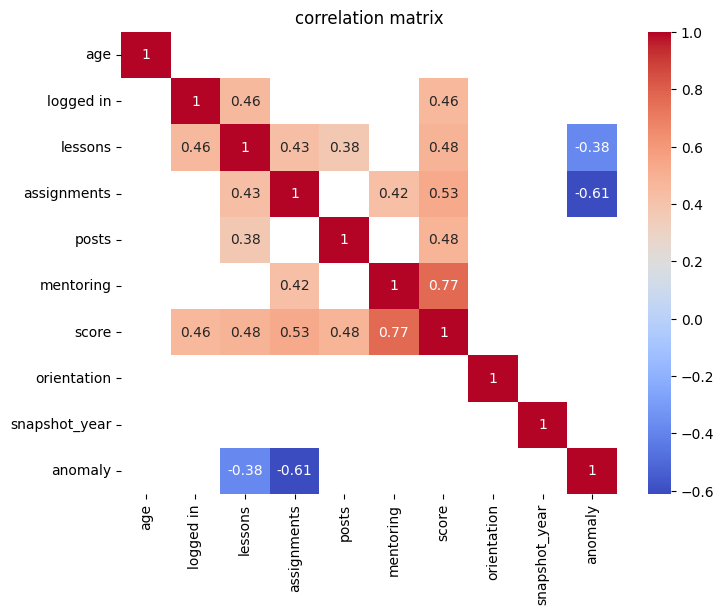

In [46]:
# Correlation Matrix (filtered at |r| >= 0.30) for simplier visualisation
# In applied data science, correlations below 0.30 are typically considered weak  
# and rarely influence model behavior or feature engineering decisions.


plt.figure(figsize=(8,6))
corr = df.drop(columns=['Unnamed: 0']).corr(numeric_only=True)
sns.heatmap(corr[(corr > 0.3) | (corr < -0.3)], annot=True, cmap='coolwarm')
plt.title('correlation matrix')
plt.show()

### Insights from the Correlation Matrix

The filtered correlation matrix (|r| >= 0.30) reveals several important structural patterns in the dataset:

#### 1. **Mentoring looks like strongest predictor of the target (score)**
- `score ↔ mentoring`: **r ≈ 0.78** — this is the only *strong* correlation in the dataset.
- This suggests that participation in mentoring is a major driver of student success OR sucsessful students might most likely participate in mentoring program

#### 2. **Student activity features form a coherent cluster**
Moderate correlations appear between:
- `logged_in`, `lessons`, `assignments`, `posts`

These features shows **overall engagement level** — higher activity in one metric tends to associate with higher activity in others.

This is important for modeling because:
- they may contribute overlapping information  
- multicollinearity should be monitored  
- dimensionality reduction / feature grouping may be useful later

#### 3. **Several activity features moderately relate to the score**
- `score ↔ logged_in`: r ≈ 0.46  
- `score ↔ lessons`: r ≈ 0.48  
- `score ↔ posts`: r ≈ 0.48  
- `score ↔ assignments`: r ≈ 0.53  

All are moderate, consistent, and positive. Probably students who engage more tend to perform better.

#### 4. **Age shows weak correlations with behavior**
- `age` correlates only weakly with any behavioral feature
- This suggests that age is unlikely to be an important predictor for the score.

#### 5. **Orientation has no meaningful relationship with any numerical feature**
- `orientation` appears isolated in the matrix  
- From a modeling perspective, this feature is a candidate for removal.

---

### Correlation heatmap Summary
The dataset exhibits a clean and interpretable structure:
- One dominant predictor (`mentoring`)
- A moderately correlated activity cluster
- Several moderate score-related behaviours
- Age and orientation are weakly informative

<Axes: title={'center': 'Relationship between activity (logged in) and score'}, xlabel='logged in', ylabel='score'>

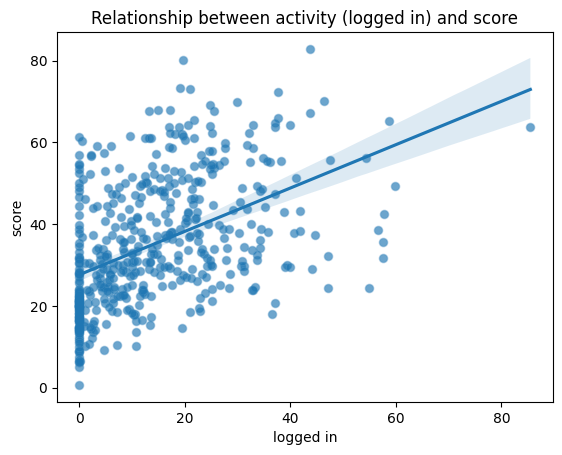

In [47]:
sns.scatterplot(x='logged in', y='score', data=df, alpha=0.5)
plt.title('Relationship between activity (logged in) and score')
sns.regplot(x='logged in', y='score', data=df, scatter_kws={'alpha':0.3})

Despite a substantial number of zero values in the `logged in` feature, the scatterplot and regression line reveal a moderate positive correlation between `logged in` and target feature `score` in the app. This suggests that, while many students have low or zero recorded logged-in time, those who spend more hours tend to achieve higher scores overall.

The presence of logged-in = 0 cases could influence correlation metrics, but the overall trend is robust and consistent with expected learning behavior.

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['logged in', 'lessons', 'assignments', 'posts']].dropna() # we exclude score because we want to predict it in future model!

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame({'feature': X.columns, 'VIF': vif})

,feature,VIF
0,logged in,2.428589
1,lessons,2.815207
2,assignments,1.461762
3,posts,2.465185


#### VIF (Variance Inflation Factor) 
is a metric that shows how strongly one feature in your data is linearly dependent on other features.

Initial heatmap suggested strong correlations among activity-related variables.
but after excluding the target variable (score), VIF values indicate only moderate interdependence (VIF ≈ 2–3).
This implies that activity metrics are not strongly redundant but are jointly correlated with performance (score), which is logical.

Variance Inflation Factor (VIF) quantifies how much a feature's variance is inflated due to linear correlation with other features.
Low VIF values (<3) indicate there is no problematic multicollinearity among activity features (`logged in`, `lessons`, `assignments`, `posts`), meaning I could safely include them together in subsequent modeling if needed.

<a id="detailed-eda-categorical-features"></a>
## Detailed EDA (categorical features)

Here I focus on categorical features: gender (sex), country of residence, participation in the mentoring program, and orientation session attendance.

Insights from hight-level EDA:
`Sex`: multiple spelling variations are visible (Female / F / female / …) - data quality issue, will be fixed during the cleaning stage.

`Country`: many rare categories + typos probably will be merged into Other during cleaning stage.

`Mentoring` and `orientation`: distribution is highly unbalanced (most are without mentoring / have not completed orientation), important to consider in modeling and metrics.


In [49]:
cat_cols = ['sex', 'country', 'mentoring', 'orientation']
df[cat_cols].dtypes

sex             object
country         object
mentoring      float64
orientation    float64
dtype: object

In [50]:
df[cat_cols].value_counts()

sex                country  mentoring  orientation
Female             Other    0.0        1.0            24
Male               Other    0.0        1.0            23
                   Germany  0.0        1.0            19
Female             Germany  0.0        1.0            19
                   Austria  0.0        1.0            16
                                                      ..
Male               Austrai  0.0        1.0             1
F                  France   1.0        0.0             1
Male               Franc    0.0        1.0             1
                   Grmany   1.0        0.0             1
Prefer not to say  Spain    0.0        1.0             1
Name: count, Length: 88, dtype: int64

### Normalising categorical labels for EDA

As seen on visualization in **Initial EDA** and output above, raw categorical features `sex`, `country` contain obvious inconsistencies. 
To make the exploratory analysis and statistical tests meaningful, 
I first standardise these labels:

- map all variants of `female/male/non-binary` to a consistent set of categories,
- group very rare countries into an `Other` class.

This is a light, structure-only cleaning step to improve interpretability of EDA.

In [51]:
# Fix garbage in categories (Country, Sex)
# Despite I am not sure we will use it as features for model I prefer to make it ready and test it anyways!

df['sex'] = df['sex'].str.strip().str.lower()
df['country'] = df['country'].str.strip().str.title()

sex_map = {
    'f': 'female', 'female': 'female',
    'm': 'male', 'male': 'male',
    'nb': 'non-binary', 'nonbinary': 'non-binary', 'non-binary': 'non-binary',
    'unknown': 'prefer_not_to_say'
}
df['sex'] = df['sex'].map(sex_map).fillna('unknown')

print(df['sex'].unique()) # checking that we have only 4 unique categories

df['country'] = df['country'].replace({
    'Grmany': 'Germany',
    'Franc': 'France',
    'Itali': 'Italy',
    'Austrai': 'Austria',
    'Othre': 'Other'
})

df['country'] = df['country'].fillna('Other')

rare = df['country'].value_counts()
rare_countries = rare[rare < 5].index
df['country'] = df['country'].replace(rare_countries, 'Other')

print(df['country'].unique())

['unknown' 'female' 'male' 'non-binary']
['Austria' 'Germany' 'Other' 'France' 'Italy' 'Spain']


Rare countries and NaN in `country` were added to category **Other**
`sex` NaN was also added to **unknown** as both are logically works for this category

In [52]:
df['sex'].value_counts()

sex
female        266
male          195
unknown        23
non-binary     16
Name: count, dtype: int64

In [53]:
df['country'].value_counts()

country
Other      150
Germany    107
Austria    102
Italy       54
Spain       44
France      43
Name: count, dtype: int64

In [54]:
print(df['mentoring'].unique())
print(df['orientation'].unique())
print(df['sex'].unique())
print(df['country'].unique())


[ 1.  0. nan]
[ 1.  0. nan]
['unknown' 'female' 'male' 'non-binary']
['Austria' 'Germany' 'Other' 'France' 'Italy' 'Spain']


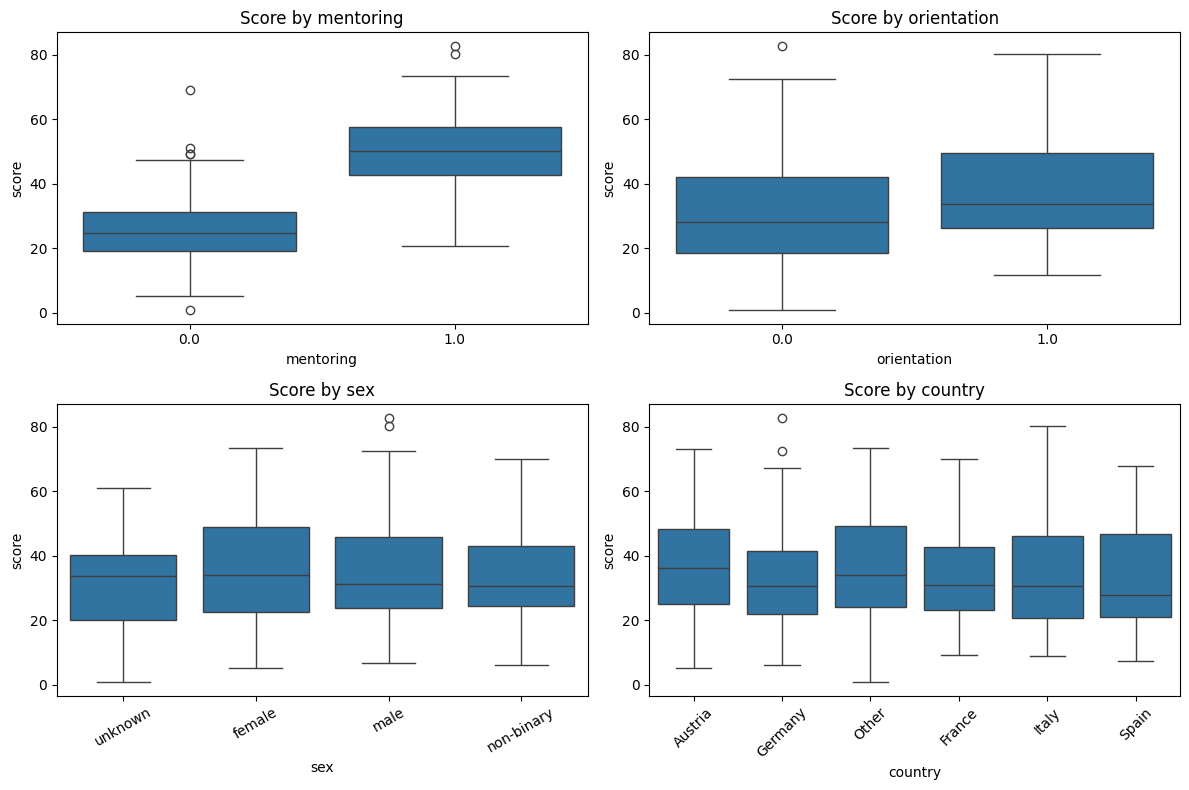

In [55]:
# visualization to connect categortical features to target feature
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='mentoring', y='score')
plt.title('Score by mentoring')

plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='orientation', y='score')
plt.title('Score by orientation')

plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='sex', y='score')
plt.title('Score by sex')
plt.xticks(rotation=30)

plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='country', y='score')
plt.title('Score by country')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Boxplots insights:**

`Mentoring`: The median and overall IQR are significantly higher in the mentor group - a strong association with academic performance.

`Orientation`: a similar but weaker effect.

`Sex`/`Country`: no obvious median shift, high box overlap which means weak or no effect on `score`.

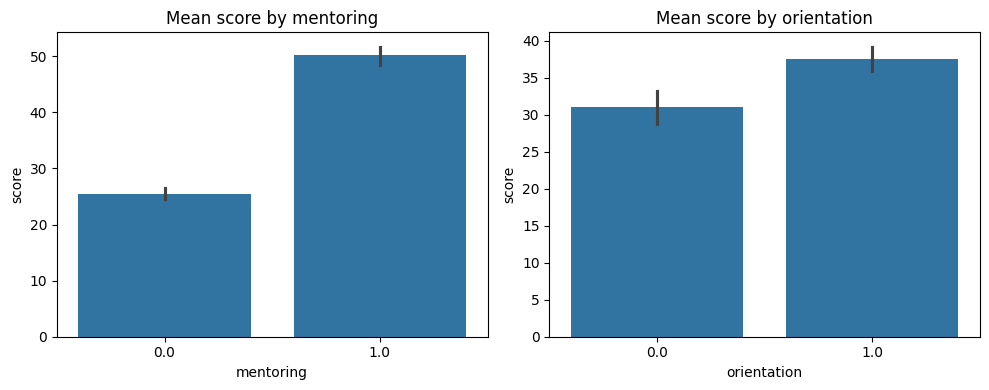

In [56]:
# visualization to connect mean score by categories most associated with it
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.barplot(data=df, x='mentoring', y='score', estimator='mean', errorbar=('ci', 95))
plt.title('Mean score by mentoring')

plt.subplot(1, 2, 2)
sns.barplot(data=df, x='orientation', y='score', estimator='mean', errorbar=('ci', 95))
plt.title('Mean score by orientation')

plt.tight_layout()
plt.show()

**Mean Score by Mentoring & Orientation — Interpretation**

The barplots show the average score for each category with 95% confidence intervals.
What is seen: 
Students in the mentoring program consistently achieve higher scores.
The mean score is noticeably higher, and the confidence intervals do not overlap with the “No mentoring” group, indicating a strong and statistically stable effect.

Orientation participation also shows a positive but weaker effect.
The difference in means is visible, but smaller, and the intervals partially overlap — suggesting a mild association.

### ANOVA test
is good idea when feature is categorical but target numerical and help me to understand importance of each feature for target `score`

In [57]:
results = []
for col in ['mentoring', 'orientation', 'sex', 'country']:
    # filtering only no-NaN and unique groups with at least 2 observations
    values = df[[col, 'score']].dropna()
    groups = [group['score'].values for name, group in values.groupby(col) if group['score'].count() >= 2]
    if len(groups) > 1:
        f_stat, p_val = f_oneway(*groups)
    else:
        f_stat, p_val = np.nan, np.nan
    results.append({'feature': col, 'F-statistic': f_stat, 'p-value': p_val})
pd.DataFrame(results)

,feature,F-statistic,p-value
0,mentoring,698.295697,2.180607e-95
1,orientation,20.858830,6.268203e-06
2,sex,0.731722,5.334266e-01
3,country,1.197156,3.093794e-01


**ANOVA analysis reveals that:**
- Both `mentoring` and `orientation` are highly significant predictors of `score` (p ≪ 0.05). (P-values presented in scientific notation (e.g., 2.18e-95, 6.27e-6) are equivalent to extremely low probabilities (practically zero), indicating very strong statistical significance compared to the conventional threshold of 0.05)

- There is no statistically significant difference in `score` across `sex` or `country` groups (p > 0.05).
This suggests mentoring participation and orientation status play a major role in students’ final results, while gender and location have minimal impact in this dataset.



### Zero-inflation in activity features

To understand how many students show *no* activity in different channels,  
I calculated the percentage of zeros in:
`assignments`, `logged in`, `lessons`, `posts`.

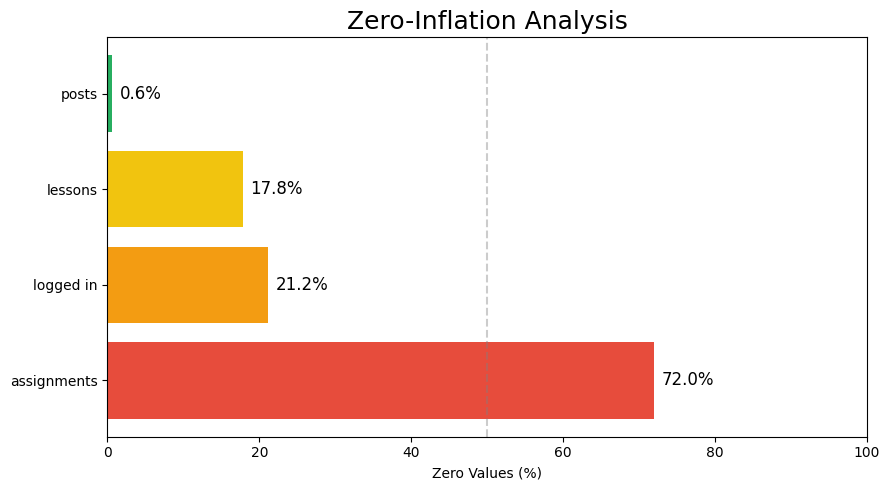

In [58]:
features = ['assignments', 'logged in', 'lessons', 'posts']
zero_percents = {col: (df[col] == 0).mean() * 100 for col in features}

zero_df = pd.DataFrame({'Feature': zero_percents.keys(), 'Zero Values (%)': zero_percents.values()})

colors = ['#e74c3c', '#f39c12', '#f1c40f', '#27ae60']

plt.figure(figsize=(9, 5))
bars = plt.barh(zero_df['Feature'], zero_df['Zero Values (%)'], color=colors)
plt.title('Zero-Inflation Analysis', fontsize=18)
plt.xlabel('Zero Values (%)')
plt.xlim(0, 100)
plt.axvline(50, color='gray', linestyle='--', alpha=0.4)


for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", va='center', fontsize=12)

plt.tight_layout()
plt.show()

- `assignments`: **72%** zeros → most students never submit assignments  
- `logged in`: **21%** zeros → a non-trivial group of students is present in the data with no login time recorded  
- `lessons`: **18%** zeros → many students do not attend lessons at all  
- `posts`: **0.6%** zeros → almost everyone posts at least once

This confirms a **strong zero-inflation**, especially for `assignments`.  
It suggests that:
- some models might need special handling,  
- and in feature engineering we may consider binary flags like “no assignments”, “no login but other activity”

### Exploratory linear model (reverse-engineering the score)

To better understand how the target `score` might be constructed,
I fitted a simple OLS regression:

`score ~ logged_in + lessons + assignments + posts + mentoring`

This is *not* part of the final modeling yet, but an exploratory sanity-check

In [59]:
features = ['logged in', 'age', 'lessons', 'assignments', 'posts', 'mentoring']
df_clean = df[features + ['score']].replace([np.inf, -np.inf], np.nan).dropna()

X = df_clean[features]
y = df_clean['score']

import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X)).fit() # linear regression 
print(model.params)
print(model.rsquared)
# const - basic 'score' if activity is 0
# 82% of the score variation is explained by these features - on a unprepared dirty data!!

const          10.732347
logged in       0.321470
age             0.057550
lessons         0.068877
assignments     2.058844
posts           1.818729
mentoring      18.930404
dtype: float64
0.8211498699041357


**Main observations:**
- The model explains about **82%** of the variance in `score` (R² ≈ 0.82),  
  which suggests that the target is almost a linear combination of activity features.
- `mentoring` has the largest positive coefficient, confirming its strong effect
  that we saw in the correlation matrix and group boxplots.
- `assignments` and `posts` also have relatively high weights,
  while `lessons` and `logged_in` contribute less.

This supports the hypothesis that `score` is a weighted activity index
rather than an independent outcome.

### Summary of EDA (High-level conclusions)

The exploratory analysis revealed that the dataset is informative but imperfect, containing several structural issues that require cleaning before modeling.

**Key findings**:

Numeric features show strong right-skewness, heavy tails, and zero-inflation (especially in assignments and logged_in).
Several high-activity power users and zero-activity students are present and seem legitimate rather than erroneous.

Categorical features had inconsistencies in naming (`sex`, `country`) and had been normalized.

`age` & `birthdate` display expected inconsistencies when calculated with “today’s” date.
Snapshot-year analysis suggests that the data was collected over multiple years (2021–2026), which explains the apparent mismatch.

The target variable (`score`) appears to be a weighted combination of activity features, as seen in correlations and an exploratory linear model.

No evidence of duplicate records; missing values are moderate and mostly concentrated in categorical fields.

**What this implies for cleaning:**

No outliers will be removed unless objectively erroneous.

The data is suitable for modeling after structured preprocessing and feature engineering

<a id="data-cleaning"></a>
## Data Cleaning

In [60]:
df.head()

,Unnamed: 0,sex,age,birthdate,country,logged in,lessons,assignments,posts,mentoring,score,orientation,snapshot_year,anomaly
0,0,unknown,24.0,2000-06-30,Austria,5.297479,4.0,1.0,3.0,1.0,44.452539,1.0,2024.0,1
1,1,female,21.0,2002-11-29,Germany,3.051044,1.0,0.0,6.0,0.0,18.985095,0.0,2023.0,1
2,2,male,21.0,2003-03-25,Other,25.042989,5.0,1.0,8.0,1.0,52.182803,0.0,2024.0,1
3,3,female,21.0,2003-03-25,France,6.482670,1.0,0.0,3.0,0.0,24.172925,1.0,2024.0,1
4,4,female,29.0,1994-12-28,Germany,9.786313,1.0,0.0,10.0,0.0,39.749603,1.0,2023.0,1


In [61]:
# deleting columns we will not need

df = df.drop(columns=['anomaly', 'snapshot_year', 'Unnamed: 0', 'birthdate_dt', 'exact_snapshot_date', 'exact_snapshot_year'], errors='ignore')

In [62]:
# brushing up types of data

df['birthdate'] = pd.to_datetime(df['birthdate'], errors='coerce')
df['mentoring'] = df['mentoring'].astype('Int64')   # it keeps NaN
df['orientation'] = df['orientation'].astype('Int64')
df['sex'] = df['sex'].astype('category')
df['country'] = df['country'].astype('category')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sex          500 non-null    category      
 1   age          489 non-null    float64       
 2   birthdate    483 non-null    datetime64[ns]
 3   country      500 non-null    category      
 4   logged in    495 non-null    float64       
 5   lessons      493 non-null    float64       
 6   assignments  488 non-null    float64       
 7   posts        495 non-null    float64       
 8   mentoring    483 non-null    Int64         
 9   score        495 non-null    float64       
 10  orientation  494 non-null    Int64         
dtypes: Int64(2), category(2), datetime64[ns](1), float64(6)
memory usage: 37.7 KB


In [64]:
df.isna().sum()

sex             0
age            11
birthdate      17
country         0
logged in       5
lessons         7
assignments    12
posts           5
mentoring      17
score           5
orientation     6
dtype: int64

There is some NaN in categories `mentoring` and `orientation` - I make an assumption that in this cxase NaN means 0 and it would be safe to replace it to 0. In this case it would not be considered as data leakage as it is not statistical imputation but rule “no record - no participation”

In [65]:
df['mentoring'] = df['mentoring'].fillna(0).astype(int)
df['orientation'] = df['orientation'].fillna(0).astype(int)

Although `logged_in` contains many valid zeros (students who never logged
in), `NaN` values represent a different situation: **missing system
records**. Based on EDA, zeros correspond to a meaningful behavioural
state (“no login”), while NaN indicates that the platform simply did not
capture the value.

Therefore, replacing NaN with 0 would mix two semantically different
states and distort the feature. I also do not fill other NaN with 0 as it would change an information in data for a model.

<a id="featureengineering-pre-split-leakage-safe"></a>
## Feature engineering (pre-split, leakage-safe)

Here I construct a small set of behaviour-based features that are computed
row-wise and do not use any information from the target or from the
global dataset distribution.

In [66]:
# has_any_assignment: at least one assignment done = 1 if not = 0
df['has_any_assignment'] = (df['assignments'] > 0).astype('Int64')

# total_activity: sum of all activities on platform
activity_cols = ['logged in', 'lessons', 'assignments', 'posts']
df['total_activity'] = df[activity_cols].sum(axis=1)

# activity_per_hour: how effective during one hour
# if logged in = 0 I do not divide
logged_safe = df['logged in'].replace(0, np.nan)
df['activity_per_hour'] = (df['lessons'] + df['assignments'] + df['posts']) / logged_safe

# completion_rate: how many assignments per completed lesson
# if lessons == 0 -> NaN (cant calc)
lessons_safe = df['lessons'].replace(0, np.nan)
df['completion_rate'] = df['assignments'] / lessons_safe

# engagement_intensity: social activity on one hour of login
df['engagement_intensity'] = df['posts'] / logged_safe

df['total_learning'] = df['lessons'] + df['assignments']

# age_group: age cohorts
age_bins = [0, 18, 25, 35, 60, np.inf]
age_labels = ['<=18', '19–25', '26–35', '36–60', '60+']

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)
df['age_group'] = df['age_group'].astype('category')

### Engineered Feature Explanations
`has_any_assignment`
Indicates if a student has completed at least one assignment (1 if assignments > 0, else 0).
**Why it matters**: Submission of any assignment is a strong early signal of academic engagement and commitment.

`total_activity`
Sum of all major activities (logged in hours, lessons, assignments, posts).
**Why it matters**: Captures overall engagement and platform usage, which often correlates with likelihood of success.

`activity_per_hour`
Sum of lessons, assignments, and posts divided by hours logged in (avoid division by zero).
**Why it matters**: Measures efficiency—how productive a student is with their online time, distinguishing passive from active users.

`completion_rate`
Ratio of assignments to lessons (NaN if no lessons).
**Why it matters**: Indicates follow-through and learning effectiveness; students who complete more assignments per lesson are generally higher performers.

`engagement_intensity`
Number of posts per logged-in hour.
**Why it matters**: Identifies students who actively participate in discussions and community, a positive predictor for performance and retention.

`total_learning`
Total of lessons + assignments.
**Why it matters**: Focuses on the “learning” aspect of engagement, helping distinguish academic from purely social participation.

`age_group`
Age cohorts/bins: <=20, 21–30, 31–50 (created with pd.cut).
**Why these bins?**

<=20: Typical age for high-school finishers and early undergraduates, often with different motivation and learning strategies.

21–30: Core group for bachelor’s/master’s students and young professionals doing career upskilling.

31–50: Mature, possibly working professionals returning for continued education or career change, with different time availability and engagement patterns.

In [67]:
df.head()

,sex,age,birthdate,country,logged in,lessons,assignments,posts,mentoring,score,orientation,has_any_assignment,total_activity,activity_per_hour,completion_rate,engagement_intensity,total_learning,age_group
0,unknown,24.0,2000-06-30,Austria,5.297479,4.0,1.0,3.0,1,44.452539,1,1,13.297479,1.510152,0.25,0.566307,5.0,19–25
1,female,21.0,2002-11-29,Germany,3.051044,1.0,0.0,6.0,0,18.985095,0,0,10.051044,2.294297,0.00,1.966540,1.0,19–25
2,male,21.0,2003-03-25,Other,25.042989,5.0,1.0,8.0,1,52.182803,0,1,39.042989,0.559039,0.20,0.319451,6.0,19–25
3,female,21.0,2003-03-25,France,6.482670,1.0,0.0,3.0,0,24.172925,1,0,10.482670,0.617030,0.00,0.462772,1.0,19–25
4,female,29.0,1994-12-28,Germany,9.786313,1.0,0.0,10.0,0,39.749603,1,0,20.786313,1.124019,0.00,1.021835,1.0,26–35


In [68]:
# saving cleaned and ready dataset with features
df.to_csv("students_clean_with_features.csv", index=False)

print("Saved to students_clean_with_features.csv")

Saved to students_clean_with_features.csv


<a id="logistic-regression-multiclass-baseline"></a>
## Logistic Regression Multiclass (baseline)

I start from dividing target `score` to categoriucal feature creating 3 categories and buidling baseline logistic regression model.
Three classes (`low`, `mid`, `high`) provide significantly more value in an educational business context than a binary "pass/fail" model:

**Business Value of the Three-Class Model**

Low performers
- require early intervention: additional mentoring sessions, reminders, adaptive lessons.
- signal a risk for retention.

Mid performers
- the largest group: they have great growth potential, but they easily "sag."
- they benefit from easy nudges and high-quality content.

High performers
- can participate in peer mentoring, project groups, and takeaway content.
- help improve the quality of the community.

**Why is binarization (just two classes) worse?**

Reducing the problem to two classes loses:
- information about the dynamics of success,
- the ability to target support,
- the distinction between struggling and stable students,
- analytical depth for administrators.

Business always wins when there is a gradation, not just “risk/no risk.”

### Metric choice for the classification task

Before move to comparing models, I first fix the **target metric** based on the business goal.

Because all three classes are relevant and the dataset is relatively balanced, (below I explain the process of deviation data to classes) I chose:

- **Primary metric:** `F1-score`  
  - averages F1 over all classes,  
  - balances precision and recall,  
  - penalizes models that perform poorly on any class (e.g., only good on “mid”).

- **Secondary metrics:**  
  - **Overall accuracy** – for a simple sanity check of how many predictions are correct.  

In [69]:
# removing lines withiut target
df = df.dropna(subset=['score'])

# Сreating 3 groups dividing by tertiles: low / mid / high
df['score_group'] = pd.qcut(
    df['score'],
    q=3,
    labels=['low', 'mid', 'high']
)

df['score_group'].value_counts()

score_group
low     165
mid     165
high    165
Name: count, dtype: int64

**Why tertiles?**
In the original dataset, the score is a continuous value, but its distribution is highly skewed and has pronounced tails. Instead of arbitrary thresholds (e.g., <30 / 30–60 / >60), I used tertiles of the distribution because this:
- ensures an even balance of classes, with each class (~33%) receiving a sufficient sample size for training the model;
- avoids subjectivity in threshold selection—the partitioning is entirely determined by the data;
- makes classes robust to outliers, since the boundaries are based on percentiles rather than means/medians;
- improves the quality and stability of multiclass models in the context of a small dataset (n=500).
From a business perspective, the tertile approach allows for comparison of students relative to their peers, rather than by absolute numbers. This aligns with the typical behavior of educational analytics models ("relative performance segmentation").

In [70]:
# Define Features (X) and Target (y)

# target variable for classification
y = df['score_group']

# columns I wont use as features
drop_cols = [
    'score',        # target feature (for regression)
    'score_group',  # target for clkassification
    'birthdate', # same info as in age
    'age' # because we use age_group feature instead
]

X = df.drop(columns=drop_cols)

In [71]:
# split the dataset into training and test sets:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% for test
    stratify=y,         # to preserve the class proportions
    random_state=42     # fixed for reproducibility
)

**Setting up preprocessing: numeric + categorical**
We need to:
- understand which columns are numeric and which are categorical;
- create different chains for them (imputation + transformations);
- collect everything in a ColumnTransformer.

In [72]:
# numerical features (int, float, в том числе Int64)
numeric_features = X.select_dtypes(
    include=['int64', 'float64', 'Int64']
).columns.tolist()

# categorical features (object, category)
categorical_features = X.select_dtypes(
    include=['object', 'category']
).columns.tolist()

numeric_features, categorical_features

(['logged in',
  'lessons',
  'assignments',
  'posts',
  'mentoring',
  'orientation',
  'has_any_assignment',
  'total_activity',
  'activity_per_hour',
  'completion_rate',
  'engagement_intensity',
  'total_learning'],
 ['sex', 'country', 'age_group'])

**To avoid data leakage and maintain a clean workflow, preprocessing is wrapped inside a ColumnTransformer**

`Numerical features`

Pipeline:

SimpleImputer(strategy="median")
Median is robust to skewed distributions and outliers.

StandardScaler()
Logistic Regression converges faster and performs more stably when features are on similar scales.

`Categorical features`

Pipeline:

SimpleImputer(strategy="most_frequent")
Safe choice for categorical NaNs, preserves real categories.

OneHotEncoder(handle_unknown="ignore")
Prevents errors when test-set categories are missing from the train-set.

This ensures that all preprocessing happens inside cross-validation, preventing leakage.

In [73]:
# pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # if a country is included in the test that wasn't in the train it will be ignored
])

# common preprosessor
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

**Adding and fitting baseline model**

It is simple, interpretable, and fast.

It supports true multiclass (softmax) classification.

It provides linear, easily understandable feature effects.

It serves as a clean reference point for all later models (RandomForest, PCA models, etc.).

In [74]:
# adding a model: Logistic Regression (baseline)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        max_iter=1000,
        solver='lbfgs', # multiclass, not one-vs-rest
        class_weight='balanced'
    ))
])

# train the model
clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Accuracy: 0.8383838383838383

              precision    recall  f1-score   support

        high       0.84      0.82      0.83        33
         low       0.94      0.91      0.92        33
         mid       0.74      0.79      0.76        33

    accuracy                           0.84        99
   macro avg       0.84      0.84      0.84        99
weighted avg       0.84      0.84      0.84        99



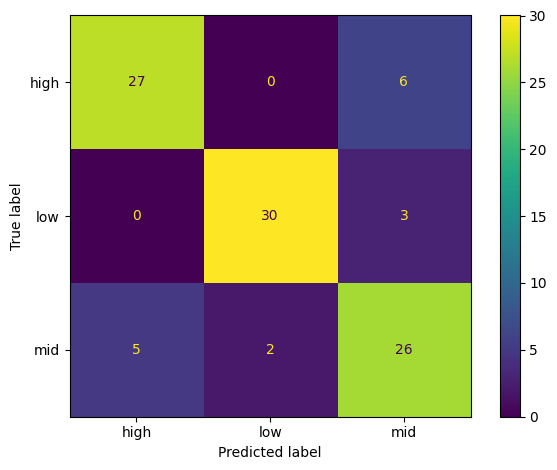

In [75]:
# calculating metrics

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.tight_layout()
plt.show()

### Baseline Model — Results & Interpretation

After training the baseline multiclass Logistic Regression model, I evaluate its performance on the held-out test set.

Test Accuracy ~0.84

This is a strong baseline for a 3-class educational prediction task with only ~500 rows and moderate feature noise.

**Interpretation**
1. The model performs well across all three target groups.

Even without feature engineering, regularization tuning, or model selection, Logistic Regression achieves ~84% accuracy, which establishes a solid baseline.

2. `Low` performers” are easiest to classify (F1 ≈ 0.92).

This likely reflects strong, easily detectable behavioral patterns among low-engagement students.

- They log in less
- Submit fewer assignments
- Engage minimally across the platform

The model captures these signals very effectively.

3. `Mid` is the hardest class (F1 ≈ 0.76).

This is typical in 3-tier educational classification:

“Mid” behaves partly like “high”

Partly like “low”

Has the most internal variability

So confusion between mid - high is expected at this stage.

4. **Confusion Matrix** reveals meaningful structure

Typical errors:

Some `high` students are predicted as `mid`

Some `mid` students are predicted as `high`

These errors follow the natural continuum of performance rather than random noise, which is exactly what we want to see.

5. **Why this baseline matters**

This result sets the foundation for further improvements:

- Interaction terms
- Log transformations
- Regularization tuning
- PCA experiments
- Comparison with tree-based models

Any future model must be meaningfully better than this 0.84 benchmark to justify added complexity.

### Baseline model features interpretation

Logistic Regression is an interpretable model, so examining its coefficients helps understand which behaviors most strongly predict student performance.

In [76]:
# extracting trained model and preprocessor from  pipeline
logreg = clf.named_steps['model']
pre = clf.named_steps['preprocess']

# features from ColumnTransformer
num_features = pre.transformers_[0][2]
cat_features = pre.transformers_[1][2]

#print("Numeric", num_features)
#print("Categorical", cat_features)

# OneHotEncoder for categorical features
ohe = pre.named_transformers_['cat'].named_steps['onehot']
ohe_features = ohe.get_feature_names_out(cat_features)

# final list after preproc
feature_names = list(num_features) + list(ohe_features)

print("len(feature_names) =", len(feature_names))
print("coef shape =", logreg.coef_.shape)  # (n_classes, n_features)

# searching 'high' indexes
class_idx_high = np.where(logreg.classes_ == 'high')[0][0]

coefs_high = logreg.coef_[class_idx_high]

# getting df
coef_matrix = pd.DataFrame({
    'feature': feature_names,
    'coef_high': coefs_high,
    'abs_coef': np.abs(coefs_high)
}).sort_values('abs_coef', ascending=False)

coef_matrix.head(15)

len(feature_names) = 26
coef shape = (3, 26)


,feature,coef_high,abs_coef
4,mentoring,2.689442,2.689442
5,orientation,1.446692,1.446692
3,posts,1.097783,1.097783
2,assignments,1.038817,1.038817
0,logged in,0.933612,0.933612
7,total_activity,0.721568,0.721568
14,sex_non-binary,0.502637,0.502637
15,sex_unknown,-0.427919,0.427919
18,country_Germany,-0.422965,0.422965
16,country_Austria,0.308773,0.308773


The table above shows:

`coef_high` - how strongly each feature pushes a student toward the `high` score group

`abs_coef` - magnitude (strength of effect)

Features with the highest absolute coefficients are the most influential predictors in the baseline model.

**Interpretation guide:**

Positive coefficient - increases probability of “high” score

Negative coefficient - pushes prediction toward “mid/low”

One-hot encoded categories appear as binary indicators

This block gives a clear, business-friendly explanation of why the model works the way it does.

### Cross-validation baseline model
The idea is not to rely on one train/test split, but to see how the model behaves on different splits.

To assess how well the baseline model generalizes beyond a single train/test split, I evaluated it using 5-fold cross-validation. This helps detect instability, data-sensitivity, or hidden overfitting.

In [77]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# accuracy
cv_acc = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print("CV accuracy:", cv_acc)
print("Mean accuracy: {:.3f} ± {:.3f}".format(cv_acc.mean(), cv_acc.std()))

# macro-F1 for multi class task
cv_f1 = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro')
print("CV macro-F1:", cv_f1)
print("Mean macro-F1: {:.3f} ± {:.3f}".format(cv_f1.mean(), cv_f1.std()))


CV accuracy: [0.82828283 0.86868687 0.8989899  0.75757576 0.83838384]
Mean accuracy: 0.838 ± 0.047
CV macro-F1: [0.82828283 0.8684099  0.89940476 0.76117216 0.8318555 ]
Mean macro-F1: 0.838 ± 0.046


**Interpretation**
Performance is consistent across folds

The standard deviation (≈0.046–0.047) is low for a small dataset with three balanced classes.
This means the model is not overly sensitive to a particular split of the data.

2. No signs of overfitting

CV mean accuracy (≈0.838)

Test accuracy (≈0.838)

Train accuracy (≈0.85)

These values are very close which means the model generalizes well.

3. Fold 4 is slightly lower

This is expected: with only ~400 training samples per fold, small class composition shifts can temporarily hurt multinomial logistic regression.

But the drop is not catastrophic and the overall mean remains stable.

4. Macro-F1 mirrors accuracy

Macro-F1 is especially important in a 3-class task because it weights all classes equally.
The fact that macro-F1 ≈ accuracy indicates balanced performance across classes, not just on the majority group.

**Conclusion**

Cross-validation confirms that the baseline multiclass Logistic Regression is:
stable, not overfitting, reliable as a benchmark, a strong foundation for more advanced modeling (feature engineering, interactions, log-transforms, PCA)

<a id="model-2-logistic-regression-with-interaction-and-log-features"></a>
## Model 2: Logistic Regression with Interaction and Log Features

I will create a new pipeline on a clean copy of the dataset to ensure that all feature-engineering steps are fully isolated from the baseline model. This prevents data leakage, keeps preprocessing consistent inside the pipeline, and allows to compare models fairly. By branching from a copy, we guarantee that no transformations “spill” from Model 1 to Model 2.

#### Planned improvements

The goal is to move beyond the simple, linear baseline and let the model capture richer structure in the data:
- Log-transformed features
To reduce skewness and stabilize variance, especially for right-tailed numeric signals.
- Interaction features
Hand-crafted pairwise products or ratios to give a linear model access to multiplicative and non-additive relationships.


**Regularized Logistic Regression**
I'll use LogisticRegression(C, penalty='l2') to keep the model smooth and prevent the interaction features from exploding.

**Full pipeline integration**
Scaling + transformation + interaction generation + model
all combined into a single reproducible pipeline suitable for CV.

In [78]:
# working with dataset copy to make it clearer and easier
df_v2 = df.copy()

# interaction features (relational), +1 to avoid 0 in denominator
df_v2['lessons_per_login'] = df_v2['lessons'] / (df_v2['logged in'] + 1)
df_v2['assignments_per_login'] = df_v2['assignments'] / (df_v2['logged in'] + 1)
df_v2['posts_per_assignment'] = df_v2['posts'] / (df_v2['assignments'] + 1)

# log-features (log1p safe for 0)
df_v2['log_logged_in'] = np.log1p(df_v2['logged in'])
df_v2['log_total_activity'] = np.log1p(df_v2['total_activity'])

In [79]:
df_v2[['lessons_per_login', 'assignments_per_login', 'posts_per_assignment', 'log_logged_in', 'log_total_activity']].describe()

,lessons_per_login,assignments_per_login,posts_per_assignment,log_logged_in,log_total_activity
count,483.000000,478.000000,479.000000,490.000000,495.000000
mean,0.569641,0.114604,4.355068,2.097205,2.919687
std,1.126845,0.476576,2.326515,1.304680,0.767182
min,0.000000,0.000000,0.000000,0.000000,0.693147
25%,0.062657,0.000000,2.666667,1.125356,2.397895
50%,0.200580,0.000000,4.000000,2.477527,3.021490
75%,0.497238,0.027309,6.000000,3.136348,3.498942
max,8.000000,5.000000,12.000000,4.460014,4.715943


In [80]:
df_v2.head()

,sex,age,birthdate,country,logged in,lessons,assignments,posts,mentoring,score,...,completion_rate,engagement_intensity,total_learning,age_group,score_group,lessons_per_login,assignments_per_login,posts_per_assignment,log_logged_in,log_total_activity
0,unknown,24.0,2000-06-30,Austria,5.297479,4.0,1.0,3.0,1,44.452539,...,0.25,0.566307,5.0,19–25,high,0.635175,0.158794,1.5,1.840149,2.660083
1,female,21.0,2002-11-29,Germany,3.051044,1.0,0.0,6.0,0,18.985095,...,0.00,1.966540,1.0,19–25,low,0.246850,0.000000,6.0,1.398975,2.402525
2,male,21.0,2003-03-25,Other,25.042989,5.0,1.0,8.0,1,52.182803,...,0.20,0.319451,6.0,19–25,high,0.191990,0.038398,4.0,3.259749,3.689954
3,female,21.0,2003-03-25,France,6.482670,1.0,0.0,3.0,0,24.172925,...,0.00,0.462772,1.0,19–25,low,0.133642,0.000000,3.0,2.012590,2.440839
4,female,29.0,1994-12-28,Germany,9.786313,1.0,0.0,10.0,0,39.749603,...,0.00,1.021835,1.0,26–35,mid,0.092710,0.000000,10.0,2.378278,3.081282


In [81]:
# again creating same X and y for this model using same target

y_v2 = df_v2['score_group']

drop_cols = ['score', 'score_group', 'birthdate', 'age', 'logged in', 'total_activity']

X_v2 = df_v2.drop(columns=drop_cols)

In [82]:
# new train/test split for v2 using same parametrs as on baseline

from sklearn.model_selection import train_test_split

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2,
    y_v2,
    test_size=0.2,
    stratify=y_v2,
    random_state=42
)

In [83]:
# numeric/categorical for v2 model

numeric_features_v2 = X_v2.select_dtypes(
    include=['int64', 'float64', 'Int64']
).columns.tolist()

categorical_features_v2 = X_v2.select_dtypes(
    include=['object', 'category']
).columns.tolist()

numeric_features_v2, categorical_features_v2

(['lessons',
  'assignments',
  'posts',
  'mentoring',
  'orientation',
  'has_any_assignment',
  'activity_per_hour',
  'completion_rate',
  'engagement_intensity',
  'total_learning',
  'lessons_per_login',
  'assignments_per_login',
  'posts_per_assignment',
  'log_logged_in',
  'log_total_activity'],
 ['sex', 'country', 'age_group'])

In [84]:
# New preprocess and new pipeline (clf_v2) so we do no touch baseline

numeric_transformer_v2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_v2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_v2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_v2, numeric_features_v2),
        ('cat', categorical_transformer_v2, categorical_features_v2)
    ]
)

clf_v2 = Pipeline(steps=[
    ('preprocess', preprocess_v2),
    ('model', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced' 
    ))
])

Baseline (v1): 0.8383838383838383
Model v2 — with new features and log features
Accuracy: 0.9191919191919192

              precision    recall  f1-score   support

        high       0.97      0.85      0.90        33
         low       0.97      0.97      0.97        33
         mid       0.84      0.94      0.89        33

    accuracy                           0.92        99
   macro avg       0.92      0.92      0.92        99
weighted avg       0.92      0.92      0.92        99



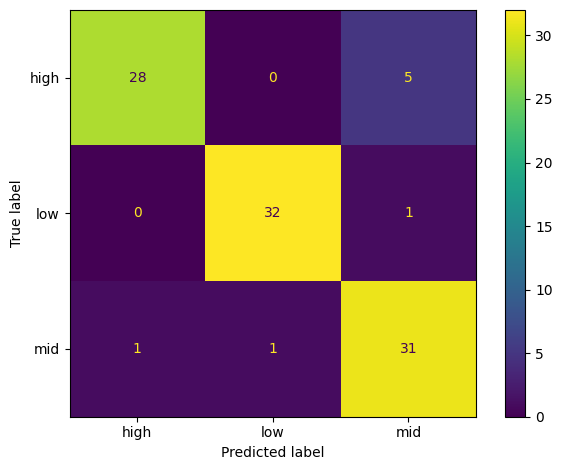

In [85]:
# trainign and compating with baseline

clf_v2.fit(X_train_v2, y_train_v2)

y_pred_v2 = clf_v2.predict(X_test_v2)

print("Baseline (v1):", accuracy_score(y_test, y_pred))
print("Model v2 — with new features and log features")
print("Accuracy:", accuracy_score(y_test_v2, y_pred_v2))  
print()
print(classification_report(y_test_v2, y_pred_v2))

ConfusionMatrixDisplay.from_estimator(clf_v2, X_test_v2, y_test_v2)
plt.tight_layout()
plt.show()

In [86]:
# cross-validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_acc_v2 = cross_val_score(clf_v2, X_v2, y_v2, cv=cv, scoring='accuracy')
cv_f1_v2 = cross_val_score(clf_v2, X_v2, y_v2, cv=cv, scoring='f1_macro')

print("CV accuracy v2:", cv_acc_v2, "mean:", cv_acc_v2.mean(), "±", cv_acc_v2.std())
print("CV macro-F1 v2:", cv_f1_v2, "mean:", cv_f1_v2.mean(), "±", cv_f1_v2.std())

CV accuracy v2: [0.83838384 0.88888889 0.94949495 0.80808081 0.88888889] mean: 0.8747474747474747 ± 0.04848484848484849
CV macro-F1 v2: [0.83986318 0.88892378 0.95004413 0.80821069 0.88729654] mean: 0.8748676646757394 ± 0.048315664609960424


### Model 2 Interpetation

After enriching the dataset with carefully engineered interaction ratios and log-transformed features, the upgraded Logistic Regression model shows a clear and meaningful improvement over the baseline. Compared to the baseline Logistic Regression (accuracy ≈ 0.83, macro-F1 ≈ 0.83),  
the improved model with interaction and log-transformed features reaches:

- **~0.92** accuracy on the held-out test set (+8 percentage points),
- **~0.88** mean macro-F1 under 5-fold cross-validation (+4 percentage points).

This suggests that the improvement is not just due to a lucky train/test split,  
but reflects a real gain in generalization performance.


Performance remains consistently high across folds (≈0.88 macro-F1).

The spread (~0.05) is expected for a small tabular dataset, where each fold slightly changes class composition.

No signs of overfitting: cross-validated performance closely matches test accuracy.

Fold-to-fold differences indicate natural variance, not model instability.

Overall, Model 2 generalizes well and clearly outperforms the baseline.

In [87]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# the same cv I used above
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'model__C': [0.01, 0.1, 1, 3, 10],
    #'model__class_weight': [None, 'balanced'], - do not need it as classes are balanced 
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['saga', 'lbfgs'],
    'model__max_iter': [500, 1000, 2000],
    'model__tol': [1e-4, 1e-5]
}


grid = GridSearchCV(
    estimator=clf_v2, # same pipeline
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro', # f1_macro is more informative than accuracy for our case
    n_jobs=-1,
    #error_score='raise'
)

grid.fit(X_train_v2, y_train_v2)

print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Best params: {'model__C': 1, 'model__max_iter': 2000, 'model__penalty': 'l1', 'model__solver': 'saga', 'model__tol': 1e-05}
Best CV macro-F1: 0.8889474798596538


/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Best CV marco-F1 after HPT is 0.8889474798596538**

Was **CV macro-F1 v2: [0.83986318 0.88892378 0.95004413 0.80821069 0.8972158 ] mean: 0.876851516786583 ± 0.04898428542074939**

these changes does not look significant but let's try to fit model with it anyways:

Accuracy (best tuned model): 0.9292929292929293

              precision    recall  f1-score   support

        high       0.97      0.85      0.90        33
         low       0.97      1.00      0.99        33
         mid       0.86      0.94      0.90        33

    accuracy                           0.93        99
   macro avg       0.93      0.93      0.93        99
weighted avg       0.93      0.93      0.93        99



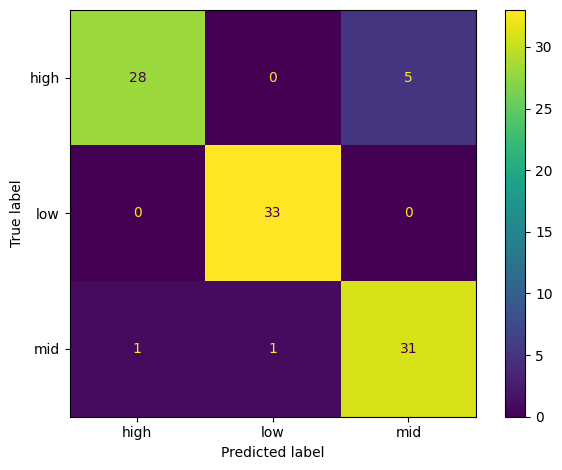

In [88]:
best_clf = grid.best_estimator_

y_pred_best = best_clf.predict(X_test_v2)

print("Accuracy (best tuned model):", accuracy_score(y_test_v2, y_pred_best))
print()
print(classification_report(y_test_v2, y_pred_best))

ConfusionMatrixDisplay.from_estimator(best_clf, X_test_v2, y_test_v2)
plt.tight_layout()
plt.show()

Note: GridSearchCV performs internal cross-validation during hyperparameter tuning.
The best estimator is then refit on the full training data.  
For final model evaluation and reporting, assess performance on a separate hold-out test set.
Additional cross-validation is optional and can be used for further robustness checks or reporting variance across folds.

After hyperparameter tuning, the classification metrics did not materially change.
This is expected for a strong logistic regression on a well-balanced, linearly-separable dataset.
Hyperparameter changes (solver, penalty) make little difference when most features already contain clear predictive information.

<a id="model-3-logistic-regression-with-pca"></a>
## Model 3: Logistic Regression with PCA

I applied PCA after preprocessing and tuned the number of components to see if it gives an upgrade to model's metrics.

Accuracy (with PCA): 0.8888888888888888

              precision    recall  f1-score   support

        high       0.87      0.82      0.84        33
         low       1.00      0.97      0.98        33
         mid       0.81      0.88      0.84        33

    accuracy                           0.89        99
   macro avg       0.89      0.89      0.89        99
weighted avg       0.89      0.89      0.89        99



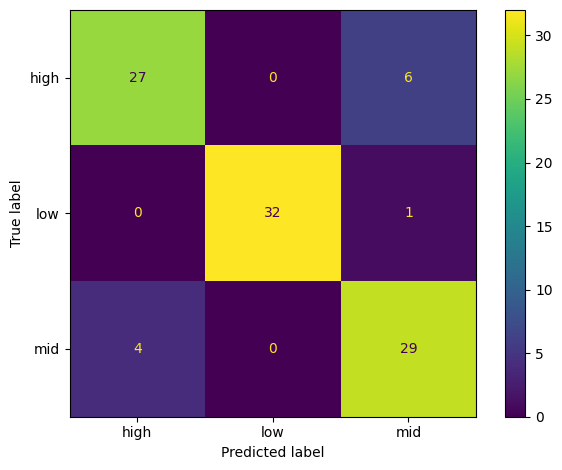

In [89]:
# numeric features same as before:
numeric_features_v2 = X_v2.select_dtypes(
    include=['int64', 'float64', 'Int64']
).columns.tolist()

categorical_features_v2 = X_v2.select_dtypes(
    include=['object', 'category']
).columns.tolist()

# numeric pipeline + PCA
numeric_transformer_pca = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=7))   # I change and see how mertics changes
])

categorical_transformer_pca = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_pca = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pca, numeric_features_v2),
        ('cat', categorical_transformer_pca, categorical_features_v2)
    ]
)

clf_pca = Pipeline(steps=[
    ('preprocess', preprocess_pca),
    ('model', LogisticRegression(
        max_iter=1000,
        solver='saga',
        class_weight='balanced'
    ))
])

# learn and compare

clf_pca.fit(X_train_v2, y_train_v2)

y_pred_pca = clf_pca.predict(X_test_v2)

print("Accuracy (with PCA):", accuracy_score(y_test_v2, y_pred_pca))
print()
print(classification_report(y_test_v2, y_pred_pca))

ConfusionMatrixDisplay.from_estimator(clf_pca, X_test_v2, y_test_v2)
plt.tight_layout()
plt.show()

Full PCA drastically hurt performance (down to ~0.70), which is expected on small tabular datasets — too much information is lost.

After experimenting with several values, **PCA with 7 components** gave the best balance between compression and predictive power.

Model results (PCA, n=7)

Accuracy: ~0.89

Macro F1: ~0.89

Performance is slightly below the engineered Model v2 (~0.92), but significantly better than the baseline (0.83).

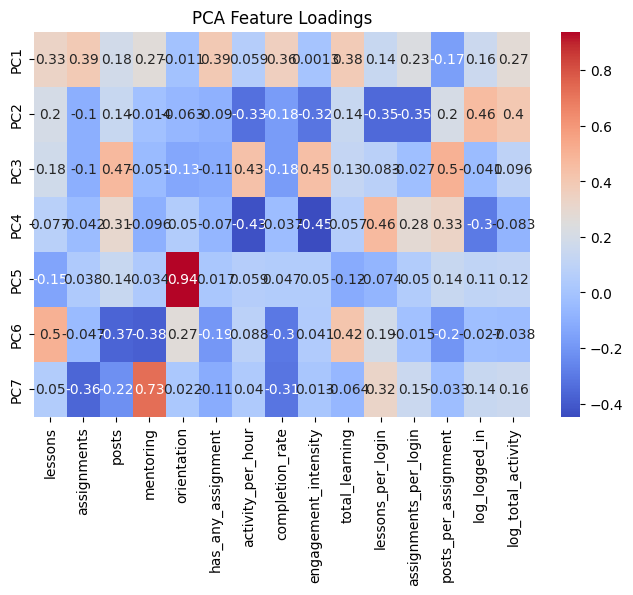

In [90]:
pca = clf_pca.named_steps['preprocess'].named_transformers_['num'].named_steps['pca']
loadings = pca.components_  # dimencion: (n_components, n_features)

loadings_df = pd.DataFrame(loadings, columns=numeric_features_v2, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

plt.figure(figsize=(8,5))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
plt.title('PCA Feature Loadings')
plt.show()

PCA confirmed that most variance in the dataset is driven by the same engagement features we identified earlier (mentoring, orientation, posts, total_activity).
The first few principal components are dominated by these variables, which is consistent with our previous feature importance analysis.

PCA an unsupervised transformation: it doesn't know which features are important for the target, but simply maximizes variance so PCA might be more useful If I could have much more highly correlated features but test model with PCA still worth trying.

<a id="model-4-random-forest"></a>
## Model 4: Random Forest

#### Why apply Random Forest to this classification task?
Robust to feature engineering: Random Forests can capture complex, nonlinear relationships between engineered features and target classes without requiring strict assumptions about data distribution.

Resistant to overfitting: Tree ensembles leverage bootstrapping and random feature selection, making them less prone to memorizing noise compared to single decision trees, especially with proper regularization.

Handles mixed data easily: RF models naturally accommodate both numerical and categorical inputs, including those generated via one-hot encoding.

Provides feature importance: Random Forests estimate the contribution of each feature to prediction accuracy, enabling transparent evaluation and iterative model improvement.

Strong baseline: With balanced classes and a compact, well-chosen feature set, Random Forests serve as a high-quality reference point for further model developments on small-to-medium educational datasets.

In [91]:
# again create a copy of dataframe but use pipeline the same way I used it before
df_v3 = df.copy()

# interaction features 
df_v3['lessons_per_login'] = df_v3['lessons'] / (df_v3['logged in'] + 1)
df_v3['assignments_per_login'] = df_v3['assignments'] / (df_v3['logged in'] + 1)
df_v3['posts_per_assignment'] = df_v3['posts'] / (df_v3['assignments'] + 1)

# log-features
df_v3['log_logged_in'] = np.log1p(df_v3['logged in'])
df_v3['log_total_activity'] = np.log1p(df_v3['total_activity'])


y_v3 = df_v3['score_group'] # target

drop_cols = ['score', 'score_group', 'birthdate']

X_v3 = df_v3.drop(columns=drop_cols)

# train-test split
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(
    X_v3,
    y_v3,
    test_size=0.2,
    stratify=y_v3,
    random_state=42
)

In [92]:
# here I add numeric and categoric features to Pipeline manually because this is subject to play and test different features for model
numeric_features = ['logged in', 'lessons', 'assignments', 'posts',
       'mentoring', 'orientation', 'has_any_assignment', 'engagement_intensity', 'total_learning', 'lessons_per_login',
       'log_total_activity']

categorical_features = ['sex', 'country', 'age_group']

numeric_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_tree = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_tree, numeric_features),
        ('cat', categorical_transformer_tree, categorical_features)
    ]
)

#### Random Forest: Hyperparameter Tuning and Feature Selection
To maximize model performance, I experimented manually with combinations of engineered features and core Random Forest hyperparameters:

**Feature selection:**
Iteratively added, removed, and transformed input variables, focusing on activity, mentoring, and engagement indicators.
Low-importance categorical features were excluded based on feature importance analysis.

**Tree ensemble size** (`n_estimators`):
Tested values from 100 to 300 to ensure stability of predictions.

**Maximum tree depth** (`max_depth`):
Varied depth limits (None, 7–10) to balance predictive power and generalization.

**Minimum leaf samples** (`min_samples_leaf`) and split threshold (min_samples_split):
Adjusted to reduce overfitting, with values from 3 to 15 to control tree granularity.

**Feature subsampling** (`max_features`):
Tuned the proportion of features considered at each split (e.g., 0.3–0.5) to increase diversity across trees.

These tuning steps helped control overfitting, improve the model’s ability to generalize, and clarify feature relevance for multiclass prediction.

Manual hyperparameter adjustment and feature engineering were key steps in refining model accuracy and interpretability for this educational classification task.

The code below and features above provided me the best performance for RF model on this bdata.

RF — accuracy: 0.8787878787878788

              precision    recall  f1-score   support

        high       0.88      0.85      0.86        33
         low       1.00      0.91      0.95        33
         mid       0.78      0.88      0.83        33

    accuracy                           0.88        99
   macro avg       0.89      0.88      0.88        99
weighted avg       0.89      0.88      0.88        99



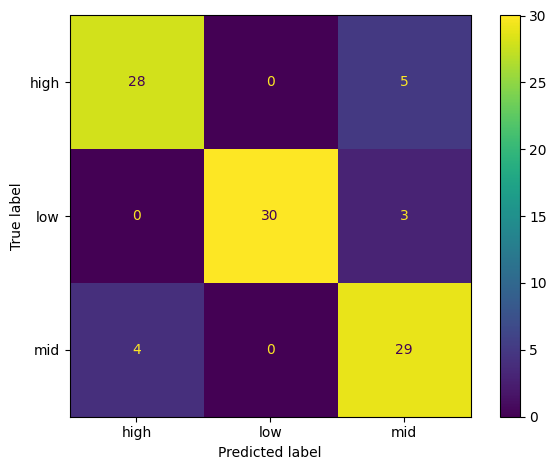

In [93]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ('preprocess', preprocess_tree),
    ('model', RandomForestClassifier(
        n_estimators=300,          # tried 100-200, 200 mostly does not give any difference while 100 makes performance lower
        max_depth=10,              # played with dept, 7-10/None does not make a big difference while <7 makes worser
        min_samples_leaf=3,       # tried 5 or more but 3 gaves better result
        min_samples_split=15,     # tried also 10
        max_features=0.5,
        random_state=42,
        n_jobs=-1                
    ))
])

rf_clf.fit(X_train_v3, y_train_v3)

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_rf = rf_clf.predict(X_test_v3)

print("RF — accuracy:", accuracy_score(y_test_v3, y_pred_rf))
print()
print(classification_report(y_test_v3, y_pred_rf))

ConfusionMatrixDisplay.from_estimator(rf_clf, X_test_v3, y_test_v3)
plt.tight_layout()
plt.show()

#### Feature importance

let's see based on which features Random Forest model does it's predictions:

In [94]:
preprocess = rf_clf.named_steps['preprocess']

# feature names after One-Hot
ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

rf_model = rf_clf.named_steps['model']
importances = rf_model.feature_importances_

feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(30)

,feature,importance
4,mentoring,0.334758
10,log_total_activity,0.236574
5,orientation,0.131395
0,logged in,0.067803
3,posts,0.057197
8,total_learning,0.037323
1,lessons,0.024938
2,assignments,0.024189
6,has_any_assignment,0.021254
7,engagement_intensity,0.020127


#### Random Forest feature Importance insigths:

Random Forest feature importance analysis highlighted mentoring, log-transformed activity, and orientation as the most influential predictors of student performance.
These patterns consistently align with findings from other models, which separately emphasized engagement, mentoring, and core activity features.

`Mentoring`:
Emerged as the strongest predictor, supporting prior evidence that social and academic support correlate tightly with high performance.

`Log total activity`:
Demonstrated substantial predictive value, confirming that overall platform engagement—especially when transformed for scale—captures robust signals for distinguishing student groups.

`Orientation` and `posts`:
Both contributed meaningfully, echoing similar importance rankings in baseline models and PCA loadings.

Low-importance categorical features (such as `country`, `age group`, and `sex`), identified by the Random Forest, also matched other models’ minimal contribution, indicating these demographic variables are less relevant for this task as I though during EDA.

Feature importance analysis confirms the central role of mentoring, activity, and orientation.
This consistency across models reinforces the reliability of results and supports data-driven decisions for improving educational interventions.

#### Random Forest Cross-Validation

In [95]:
rf_acc = cross_val_score(rf_clf, X_train_v3, y_train_v3,
                         cv=cv, scoring='accuracy', n_jobs=-1)
rf_f1  = cross_val_score(rf_clf, X_train_v3, y_train_v3,
                         cv=cv, scoring='f1_macro', n_jobs=-1)

print("RF CV accuracy:", rf_acc, "mean:", rf_acc.mean(), "±", rf_acc.std())
print("RF CV macro-F1:", rf_f1, "mean:", rf_f1.mean(), "±", rf_f1.std())

RF CV accuracy: [0.7625     0.83544304 0.89873418 0.91139241 0.81012658] mean: 0.8436392405063291 ± 0.055497379588258726
RF CV macro-F1: [0.75638833 0.8386964  0.89785639 0.90973224 0.81416453] mean: 0.8433675781003146 ± 0.05623758142476515


### Random Forest - Cross-Validation Performance

Despite some variance, the Random Forest consistently performs slightly below the engineered Logistic Regression.  
This confirms that most of the predictive signal can be captured by a linear
model with carefully designed features.

Random Forest mainly serves as a non-linear sanity check:
it reaches comparable performance and highlights similar key features
(mentoring, orientation, logged-in activity, engagement intensity), but does
not outperform Logistic Regression in my case

<a id="classification-summary-and-model-choice"></a>
## Classification summary and model choice

I compared several supervised models for predicting the **engagement group**
of a student (`score_group`: low / mid / high):

- **Baseline Logistic Regression (Model v1)**  
  – Features: raw activity counts (`logged in`, `lessons`, `assignments`,
    `posts`, `mentoring`, `orientation`)  
  – Test accuracy ≈ **0.83**, macro-F1 ≈ **0.83**  
  – Simple, interpretable, but leaves noticeable room for improvement.

- **Logistic Regression with engineered features (Model v2)**  
  – Added aggregated and ratio features (`total_activity`,
    `has_any_assignment`, `engagement_intensity`, `completion_rate`,
    `total_learning`) and log-transformed activity (`log_logged_in`,
    `log_total_activity`)  
  – Test accuracy ≈ **0.92**, macro-F1 ≈ **0.92**  
  – 5-fold cross-validated macro-F1 ≈ **0.88**, showing good stability.  
  – After light hyperparameter tuning (L1 regularization with `saga`), the
    model improves slightly in cross-validation but keeps similar test
    performance.

- **PCA + Logistic Regression**  
  – Dimensionality reduction to 7 components  
  – Test accuracy ≈ **0.89**, macro-F1 ≈ **0.89**  
  – Performs worse than Model v2, but confirms that most variance is
    captured by a lower-dimensional structure.

- **Random Forest classifier**  
  – Test accuracy ≈ **0.88**, macro-F1 ≈ **0.88**,  
    with 5-fold macro-F1 ≈ **0.84**  
  – Confirms the same key predictors as Logistic Regression, but does not
    outperform the engineered linear model on this small dataset.

**Final choice:**  
I select **Logistic Regression with engineered features (Model v2)** as the
main classification model. It offers the **best trade-off between accuracy,
stability, and interpretability**. Across all models, the most important
features are:

- participation in **mentoring** and **orientation**,  
- overall platform activity (`logged in`, `total_activity`),  
- content-related engagement (`lessons`, `assignments`, `posts`,
  `engagement_intensity`).

For the university, this means that **structured support (mentoring,
orientation) and consistent engagement with the platform are strongly linked
to better outcomes**. These are the levers that can be used to support
students at risk (low activity, no mentoring) and to reinforce what works
well for high performers.

<a id="regression-task-predicting-continuous-student-score"></a>
## Regression task: predicting continuous student score

So far, I framed the problem as a **multiclass classification** task
(`score_group`: low / mid / high). This is useful for high-level decision
making (e.g., who is at risk vs. performing well), but it discards
information by grouping a continuous score into only three buckets.

In this section, I switch to a **regression formulation**:

> **Goal:** predict the *continuous* `score` (0–100) for each student based on
> their activity and participation in support programs.

This setup allows me to:
- use the full variability of the target instead of coarse groups,
- quantify prediction quality with regression metrics (R², MAE, RMSE),
- check whether the relationship between engagement and performance is
  approximately linear,
- compare simple linear models (OLS, Ridge, Lasso) and see which features
  they keep or discard.

I reuse the cleaned dataset and the core activity-related features
(`logged in`, `lessons`, `assignments`, `posts`, `mentoring`, `orientation`,
`has_any_assignment`, `total_activity`, `engagement_intensity`,
`completion_rate`, `total_learning`), and start with a simple linear
baseline before adding more advanced feature engineering.

### Metric choice for the regression task
From a business perspective:

- Over- and underestimation are equally undesirable (a +5 and −5 point error feel similar).
- We want a model that captures most of the variation in scores (who is generally doing better or worse).
- At the same time, stakeholders care about **errors measured in score points**, not only in percentages.

Given this, I used a combination of metrics:

- **Primary optimisation metric:** `R²`  
  - used in cross-validation and hyperparameter tuning (`scoring='r2'`),  
  - measures the proportion of variance in the score explained by the model,  
  - convenient to compare different models on the same scale.

- **Secondary, business-facing metrics:**  
  - **MAE (Mean Absolute Error)** – average error in score points, easy to interpret (“on average the model is off by ~4 points”).  
  - **RMSE (Root Mean Squared Error)** – similar to MAE but penalises larger errors more strongly, useful to check if the model occasionally makes very large mistakes.

In all model comparisons I will report R² together with MAE and RMSE.

<a id="model-5-baseline-linear-regression"></a>
### Model 5: Baseline Linear Regression

Like in classification task, I first start with building baseline regression model - linear regression is great basic model for this case.
I will copy dataframe and work with it's copy, drop off target variable:

In [96]:
df.columns

Index(['sex', 'age', 'birthdate', 'country', 'logged in', 'lessons',
       'assignments', 'posts', 'mentoring', 'score', 'orientation',
       'has_any_assignment', 'total_activity', 'activity_per_hour',
       'completion_rate', 'engagement_intensity', 'total_learning',
       'age_group', 'score_group'],
      dtype='object')

In [97]:
# will build regression models with this copy df
df_reg_clean = df.dropna(subset=['score']).copy()

[Train] R² = 0.8964223842881794, MAE = 3.7053533254671596, RMSE = 4.958427233488836
[Test] R² = 0.8722784478464007, MAE = 4.122609557345388, RMSE = 5.795301124577131


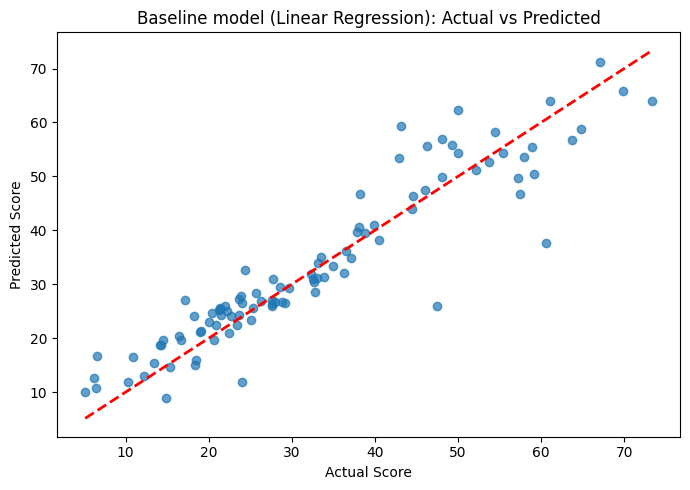

In [98]:
# building pipeline for linear regression baseline

# Target and features
target = 'score'

numeric_features_reg = [
    'logged in',
    'lessons',
    'assignments',
    'posts',
    'mentoring',
    'orientation',
    'has_any_assignment',
    'total_activity',
    'completion_rate',
    'age',                  # I conside age as numeric is better for regression task than age as category
    'engagement_intensity',
    'total_learning'
]

categorical_features_reg = ['sex', 'country']

X_reg = df_reg_clean[numeric_features_reg + categorical_features_reg].copy()
y_reg = df_reg_clean[target].copy()

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=42
)

# preprocessing - numerical/categorical features
numeric_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_reg, numeric_features_reg),
        ('cat', categorical_transformer_reg, categorical_features_reg)
    ]
)

# baseline model
reg_baseline = Pipeline(steps=[
    ('preprocess', preprocess_reg),
    ('model', LinearRegression())
])

# training
reg_baseline.fit(X_train_reg, y_train_reg)

# evaliation
y_train_pred = reg_baseline.predict(X_train_reg)
y_test_pred = reg_baseline.predict(X_test_reg)

def print_reg_metrics(y_true, y_pred, label=''):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'[{label}] R² = {r2}, MAE = {mae}, RMSE = {rmse}')

print_reg_metrics(y_train_reg, y_train_pred, label='Train')
print_reg_metrics(y_test_reg,  y_test_pred,  label='Test')

# visual
plt.figure(figsize=(7,5))
plt.scatter(y_test_reg, y_test_pred, alpha=0.7)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Baseline model (Linear Regression): Actual vs Predicted')
plt.tight_layout()
plt.show()

#### Baseline Performance

**Train set:**
- R² = **0.896**
- MAE = **3.71**
- RMSE = **4.96**

**Test set:**
- R² = **0.872**
- MAE = **4.12**
- RMSE = **5.80**

These metrics show that even the baseline linear model captures a large portion of
the variance in student scores and generalises reasonably well (no severe
overfitting: train/test performance is very consistent).

The scatterplot of predicted vs actual scores shows:

- strong positive linear relationship (points cluster around the diagonal)
- slightly higher variance in the upper score range (fewer samples → less stable)
- a symmetric spread of residuals around the regression line

This indicates a well-behaved linear model with no critical systematic errors.

#### Baseline Takeaway

The baseline Linear Regression already provides a **solid benchmark**:

- It explains **~87% of score variability** on unseen data.
- Errors are moderate (≈4–6 points), acceptable for high-level performance analytics.
- This model is simple, interpretable, and provides a reference point for
  evaluating more advanced models and feature engineering later in the project.

This forms a stable foundation before experimenting with other models

#### Baseline Model Distribution of Prediction Errors

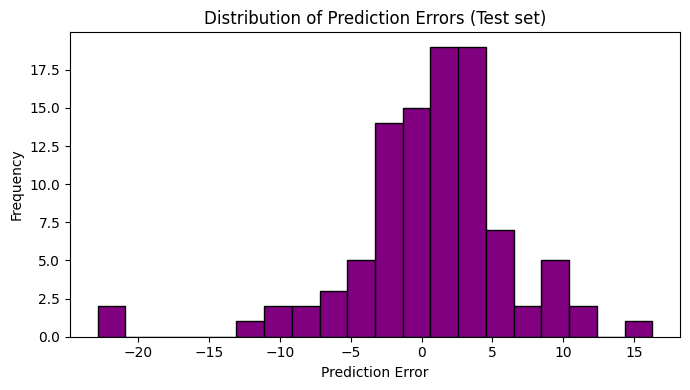

In [99]:
errors = y_test_pred - y_test_reg
plt.figure(figsize=(7,4))
plt.hist(errors, bins=20, color='purple', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Test set)')
plt.tight_layout()
plt.show()

**Errors are centered around zero**
The histogram shows a strong peak at 1-3, meaning most predictions are close to the true score.
This indicates low bias — the model does not systematically overestimate or underestimate students.

**Symmetric distribution with light tails**
Errors spread slightly in both directions, suggesting that the model performs consistently across different activity levels.
Small positive errors - mild overestimation
Small negative errors - mild underestimation

**A few large negative errors (to −20)**
These are rare cases where the model significantly underestimates the student’s score.
Such points likely correspond to unusually high-performing students (outliers) / nonlinear behavior not captured by a linear model / missing explanatory features.

**Occasional large positive errors (+10 to +15)**
These represent overestimated students — often those with high platform activity but lower final score (e.g., high engagement but low task completion).

#### Baseline model feature importance

<Figure size 800x500 with 0 Axes>

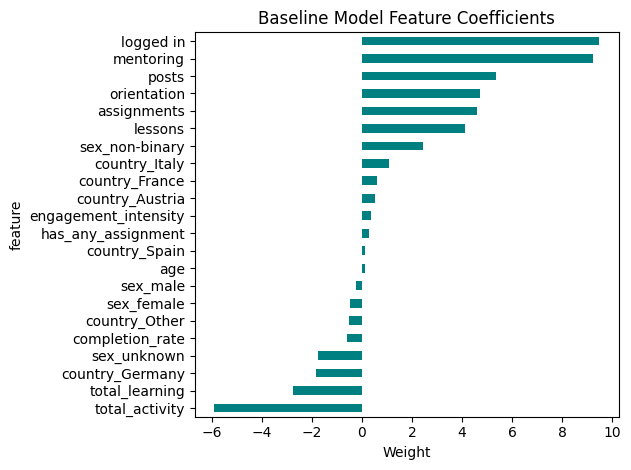

In [100]:
# extracting features names after preprocessing
ohe = preprocess_reg.named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_features_reg)
feature_names = numeric_features_reg + list(ohe_feature_names)

# getting features coefficients
coeffs = reg_baseline.named_steps['model'].coef_
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coeffs})

plt.figure(figsize=(8,5))
coef_df.sort_values('coef').plot.barh(x='feature', y='coef', legend=False, color='teal')
plt.title('Baseline Model Feature Coefficients')
plt.xlabel('Weight')
plt.tight_layout()
plt.show()

The feature importance graph shows similar pictiure we saw above while working with classification models

<a id="model-6-ridge-regression"></a>
### Model 6: Ridge Regression

Several features in the dataset were correlated (e.g., logged in, lessons, total activity, engagement_intensity).
In such settings, trying Ridge regression is good idea as it (L2) shrinks coefficients and stabilises the solution, which: reduces variance, improves generalisation, makes the model more robust across folds in cross-validation.

Creating new features to help the model: fit real-world behaviour more closely, reduce the influence of skewed distributions, improve residual structure and reduce bias at the extremes.

In [101]:
# let's work with copy again
df_reg_fe = df_reg_clean.copy()

# interaction features
df_reg_fe['lessons_assignments_interact'] = (
    df_reg_fe['lessons'] * df_reg_fe['assignments']
)

df_reg_fe['posts_mentoring_interact'] = (
    df_reg_fe['posts'] * df_reg_fe['mentoring']
)

df_reg_fe['time_on_learning_interact'] = (
    df_reg_fe['logged in'] * df_reg_fe['lessons']
)

# polynomial (quadratic) features - marking importance of several activities
df_reg_fe['logged_in_sq'] = df_reg_fe['logged in'] ** 2
df_reg_fe['total_activity_sq'] = df_reg_fe['total_activity'] ** 2
df_reg_fe['engagement_intensity_sq'] = df_reg_fe['engagement_intensity'] ** 2

#  extra log features (log1p is safe for Nan)
df_reg_fe['log_posts'] = np.log1p(df_reg_fe['posts'])
df_reg_fe['log_total_learning'] = np.log1p(df_reg_fe['total_learning'])

df_reg_fe[
    ['lessons_assignments_interact', 'posts_mentoring_interact',
     'time_on_learning_interact', 'logged_in_sq', 'total_activity_sq',
     'engagement_intensity_sq', 'log_posts', 'log_total_learning']
].describe() # to check with eyes what's going on

,lessons_assignments_interact,posts_mentoring_interact,time_on_learning_interact,logged_in_sq,total_activity_sq,engagement_intensity_sq,log_posts,log_total_learning
count,476.000000,491.000000,483.000000,490.000000,495.000000,381.000000,491.000000,476.000000
mean,4.165966,2.205703,72.355974,381.039993,818.026531,3.353911,1.767272,1.257519
std,12.854644,3.232559,169.292993,662.814179,1248.044631,26.506862,0.429574,0.833647
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.332628,100.000000,0.038999,1.609438,0.693147
50%,0.000000,0.000000,20.845331,119.067324,381.102227,0.123438,1.791759,1.098612
75%,2.000000,5.000000,75.542685,484.865900,1029.194229,0.412602,2.079442,1.791759
max,112.000000,14.000000,2539.418481,7308.324106,12257.602280,439.108188,2.708050,3.806662


In [102]:
df_reg_fe.columns

Index(['sex', 'age', 'birthdate', 'country', 'logged in', 'lessons',
       'assignments', 'posts', 'mentoring', 'score', 'orientation',
       'has_any_assignment', 'total_activity', 'activity_per_hour',
       'completion_rate', 'engagement_intensity', 'total_learning',
       'age_group', 'score_group', 'lessons_assignments_interact',
       'posts_mentoring_interact', 'time_on_learning_interact', 'logged_in_sq',
       'total_activity_sq', 'engagement_intensity_sq', 'log_posts',
       'log_total_learning'],
      dtype='object')

In [103]:
# preprocess
numeric_features_fe = [
    'age',
    'logged in',
    'lessons',
    'assignments',
    'posts',
    'mentoring',
    'orientation',
    'has_any_assignment',
    'total_activity',
    'completion_rate',
    'engagement_intensity',
    'total_learning',
    # new features
    'lessons_assignments_interact',
    'posts_mentoring_interact',
    'time_on_learning_interact',
    'logged_in_sq',
    'total_activity_sq',
    'engagement_intensity_sq',
    'log_posts',
    'log_total_learning'
]

categorical_features_fe = ['sex', 'country']

feature_cols_fe = numeric_features_fe + categorical_features_fe

X_fe = df_reg_fe[feature_cols_fe]
y_fe = df_reg_fe['score']

# train/test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe,
    test_size=0.2,
    random_state=42
)

In [104]:
numeric_tf_fe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_tf_fe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocess_fe = ColumnTransformer(
    transformers=[
        ('num', numeric_tf_fe, numeric_features_fe),
        ('cat', categorical_tf_fe, categorical_features_fe)
    ]
)

# model + preprosessing
ridge_pipe = Pipeline(steps=[
    ('preprocess', preprocess_fe),
    ('model', Ridge(max_iter=10000, random_state=42))
])

# alpha grid: regularisation power
ridge_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

ridge_gs = GridSearchCV(
    ridge_pipe,
    ridge_param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

ridge_gs.fit(X_train_fe, y_train_fe)

print("Ridge best params:", ridge_gs.best_params_)
print("Ridge best CV score (R squared):", ridge_gs.best_score_)

Ridge best params: {'model__alpha': 10}
Ridge best CV score (R squared): 0.8870578327789513


In [105]:
best_ridge = ridge_gs.best_estimator_

# train - test predictions
y_train_pred_ridge = best_ridge.predict(X_train_fe)
y_test_pred_ridge  = best_ridge.predict(X_test_fe)

print_reg_metrics(y_train_fe, y_train_pred_ridge, label='Ridge Train')
print_reg_metrics(y_test_fe,  y_test_pred_ridge,  label='Ridge Test')


[Ridge Train] R² = 0.9064907275532655, MAE = 3.4170411749137646, RMSE = 4.7112736262044255
[Ridge Test] R² = 0.896163804076805, MAE = 3.4865180398997557, RMSE = 5.225385040622177


Train/test R² is 0.01 - almost no overfitting. Overall, the model demonstrates strong generalisation and balanced error metrics, making it the preferred 
model for this task.

In [106]:
def plot_y_true_vs_pred(y_true, y_pred, title=''):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.4)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # линия y = x
    plt.xlabel('True score')
    plt.ylabel('Predicted score')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred, title=''):
    residuals = y_true - y_pred

    # scatter residuals vs predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.4)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted score')
    plt.ylabel('Residual (true - pred)')
    plt.title(title + ' — residuals vs prediction')
    plt.grid(True)
    plt.show()

    # histogram of residuals
    plt.figure(figsize=(6, 4))
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.xlabel('Residual (true - pred)')
    plt.ylabel('Count')
    plt.title(title + ' — residuals distribution')
    plt.grid(True)
    plt.show()


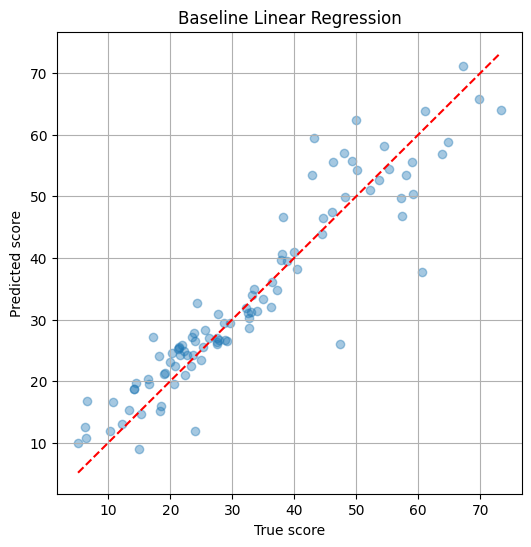

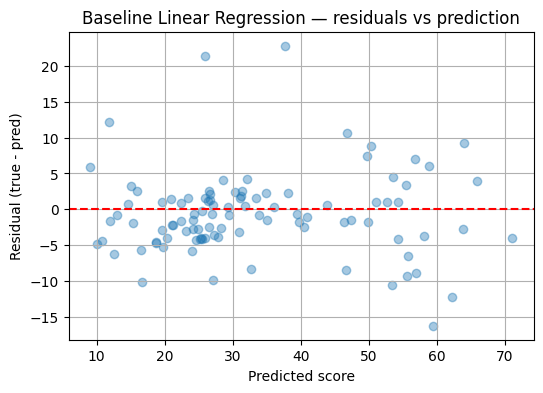

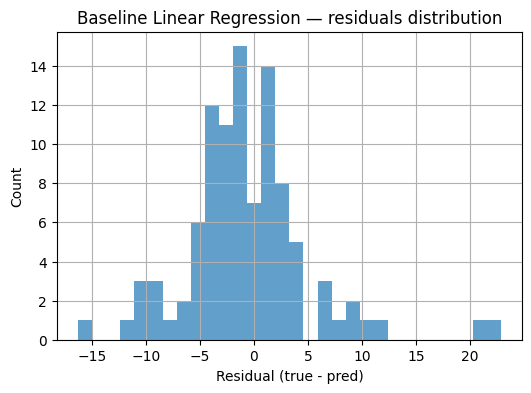

In [107]:
# baseline lin reg
plot_y_true_vs_pred(y_test_reg, y_test_pred, title='Baseline Linear Regression')
plot_residuals(y_test_reg, y_test_pred, title='Baseline Linear Regression')


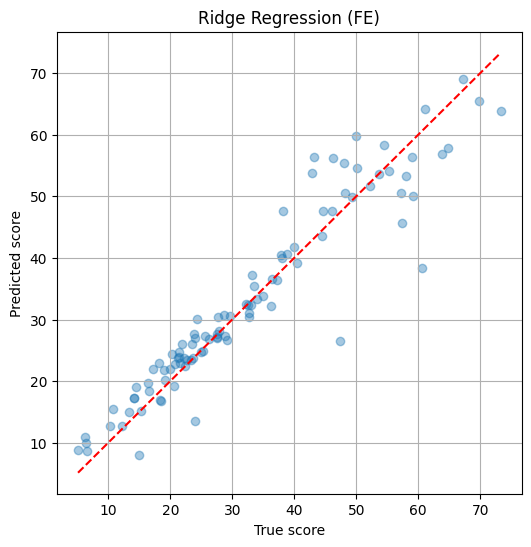

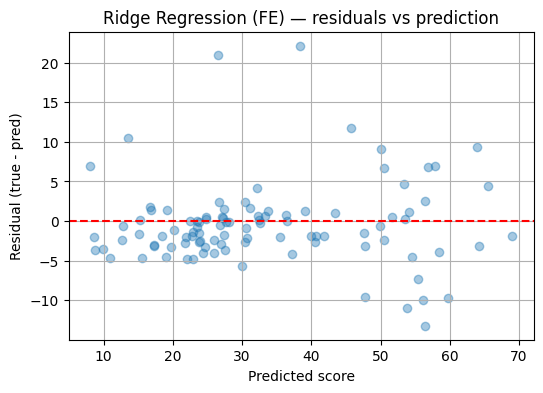

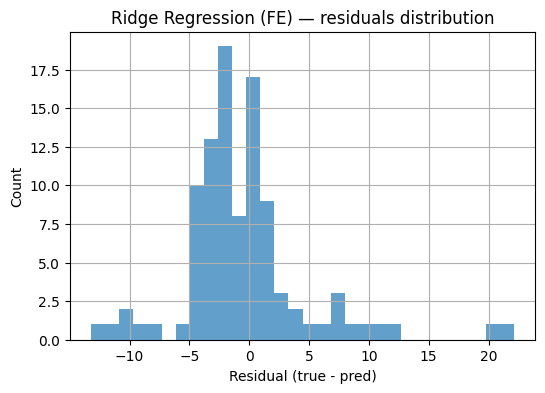

In [108]:
# prognoses Ridge on test data
y_test_pred_ridge = ridge_gs.predict(X_test_fe)

plot_y_true_vs_pred(y_test_fe, y_test_pred_ridge, title='Ridge Regression (FE)')
plot_residuals(y_test_fe, y_test_pred_ridge, title='Ridge Regression (FE)')


### A difficulty to predict highter scores

Both the baseline linear model and the Ridge regression systematically underpredict high scores (refer to a visualisation above) Visual diagnostics and feature importance suggest that most of the variance in performance can already be explained by simple engagement variables (logins, mentoring, posts, total activity), and that the remaining error at the upper tail is largely due to limited signal in the current feature set and the small number of very high-scoring students.
In other words, with the available data the model can reliably distinguish low and medium performers, but it cannot fully separate “very strong” students from “just highly engaged” ones.

To improve predictions for top performers, we would most likely need richer features (prior achievement/assignment-level results/temporal patterns/text-based indicators of understanding) or a loss function that explicitly focuses on the upper tail, rather than simply increasing model complexity.

#### Ridge feature Importance

In [109]:
best_ridge = ridge_gs.best_estimator_

preprocess = best_ridge.named_steps['preprocess']
ridge_model = best_ridge.named_steps['model']

ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_features_fe)

# features
feature_names = np.concatenate([numeric_features_fe, ohe_feature_names])

# coefficients Ridge
coefs = ridge_model.coef_

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
}).sort_values('abs_coef', ascending=False)

coef_df.head(20)

,feature,coef,abs_coef
5,mentoring,8.716858,8.716858
1,logged in,5.147543,5.147543
6,orientation,4.521482,4.521482
4,posts,3.326608,3.326608
8,total_activity,3.006764,3.006764
15,logged_in_sq,-2.501547,2.501547
24,country_Germany,-1.867013,1.867013
12,lessons_assignments_interact,1.549697,1.549697
21,sex_non-binary,1.466607,1.466607
3,assignments,1.028042,1.028042


###№ Feature importance in the Ridge model

Ranking predictors by the absolute value of their coefficients shows that the strongest effects come from engagement-related variables:

- `mentoring` (+8.7) – the strongest positive predictor: students who attend more mentoring sessions tend to achieve higher scores - we saw the same in every other models
- `logged in` (+5.1), `posts` (+3.3), `total_activity` (+3.0) and `orientation` (+4.5) – together form an "engagement bundle": frequent logins, forum activity and participation in the orientation phase are all associated with better performance.

Several nonlinear terms also appear with non-negligible coefficients:

- `logged_in_sq` (−2.5), `total_activity_sq` (−0.7), `engagement_intensity_sq` (−0.6) – negative coefficients on squared terms suggest a diminishing-returns pattern: increased activity is beneficial up to a point, after which the marginal gain decreases.
- The interaction `lessons_assignments_interact` (+1.55) indicates that students who complete many lessons *and* many assignments receive an additional performance boost, beyond the sum of the individual effects.

Categorical variables such as `country_*` and `sex_*` also have non-zero coefficients (e.g. `country_Germany` −1.9, `sex_non-binary` +1.5). However, these effects are likely driven by cohort composition and unobserved factors rather than causality, so they are interpreted with caution and are not used for decision-making.


#### Ridge concludions:
**Baseline test**
- R² = 0.872
- MAE = 4.12
- RMSE = 5.79

**Ridge test**

- R² = 0.896
- MAE = 3.49
- RMSE = 5.23

**Ridge CV R²** = 0.89


Visual diagnostics for the **baseline linear regression** and the **Ridge model** with feature engineering show very similar patterns.
For low and mid-range scores, predictions align closely with the diagonal, indicating that both models capture the general structure of the data.
However, for high-scoring students the models systematically underpredict the true scores. This suggests that while the model is good at ranking and approximating “typical” students, it struggles to accurately capture the behaviour of top performers.

The residual plots also reveal a mild heteroscedasticity pattern: residual variance increases with predicted score.
This indicates that a simple linear model with our current features may be close to its performance ceiling, and additional gains would likely require either new, more informative features (e.g. qualitative aspects of engagement) or a more flexible, non-linear model family.

<a id="conclusion"></a>
## Conclusion

In this project, I analysed student performance on an online course using 
demographic and engagement data. The main business goal was to identify 
behavioural patterns associated with course success and to support early 
risk detection for low-performing students.

I approached the problem from two angles:

- **Classification**: predicting a three-level `score_group` (low / mid / high);
- **Regression**: predicting the continuous final `score`.

From a practical and stakeholder perspective, the **classification task is 
the primary one**. 

For the business use-case of this project, the most actionable model is the **multiclass Logistic Regression classifier** (Model v2 with engineered features), 
which predicts whether a student’s final score will be **low, mid, or high**.

- Test accuracy: **≈ 0.92**
- Macro-F1 on test: **≈ 0.92**
- 5-fold cross-validated macro-F1: **≈ 0.88** (stable across folds)

I recommend this model over more complex alternatives because it offers the best trade-off between:

- **Performance** – strong, balanced accuracy across all three score groups.
- **Interpretability** – coefficients directly indicate how each behavior shifts the odds of being in a higher (or lower) score group.
- **Actionability** – the model outputs class probabilities that can be used to flag at-risk students early and to monitor segments (e.g. “likely low-score students”).


At the same time, I built a **Ridge regression model with feature engineering** 
(interactions and squared/log-transformed features) to predict the continuous 
score. The final model reached R² ≈ 0.90 on the test set with MAE ≈ 3.5, 
confirming that most of the variance in performance can already be explained 
by simple engagement features.
For continuous score prediction, a **Ridge Regression** model achieved slightly higher R² than the baseline linear model, but for decision-making in an EdTech context, the **three-class classification** (low / mid / high) is easier to operationalize.

Both models tell a consistent story:

- Engagement-related variables (`mentoring`, `logged in`, `posts`, 
  `orientation`, `total_activity`) are the strongest predictors of success.
- Non-linear terms indicate diminishing returns: very high activity adds 
  less marginal benefit than moving from low to medium engagement.
- The models perform well for low and medium performers but systematically 
  underpredict the very top scores, which likely reflects limits of the 
  current feature set rather than model choice.

Overall, I would **recommend the classification model on `score_group` as 
the operational tool** for early risk detection and student support, and 
use the **Ridge regression** as a complementary analytical model to quantify 
effect sizes and validate the robustness of the findings.

### The most important factors for success in study based on this project:

- Mentoring is the clear winner: students who participate in mentoring have a significantly higher chance of achieving high scores.

- Interaction between orientation and activity: students who attended orientation and are active on the platform perform better. This suggests that orientation enhances the effect of other activities.

- Social engagement (posts): activity in discussions and forums is strongly correlated with academic performance. Students who ask questions and interact with the community perform better.

- Total activity: total engagement (lessons + assignments + posts + online time) more likely leads to success.